In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config Completer.use_jedi = False

In [3]:
import sys, os, pickle, time, warnings, h5py

import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py
from copy import deepcopy as copy

sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
import disk_halo_mstogap as dh_msto
from transformations import func_inv_jac, func_labels, label_dict
import sf_utils

from multiprocessing import Pool

In [4]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)
from pylab import Rectangle

def save_figs(filename):
    plt.savefig(filename+'.png', bbox_inches='tight', dpi=200, facecolor='w', transparent=False)
    plt.savefig(filename+'.pdf', bbox_inches='tight', dpi=200, facecolor='w', transparent=False)
    #plt.savefig(filename+'_c.pdf', bbox_inches='tight', dpi=50, facecolor='w', transparent=False)

In [5]:
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/testselectionfunctions/'

In [6]:
def add_log_cbar(ax, vmin=0., vmax=1., cmap='viridis',
             orientation='vertical', ticks=[0,1], tick_labels=['0','1']):

    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    im = plt.cm.ScalarMappable(norm=norm, cmap=cmap); im.set_array([])

    tick_pos = (np.log(np.array(ticks)) - np.log(vmin))/(np.log(vmax)-np.log(vmin))
    cbar = plt.colorbar(im, cax=ax, orientation=orientation, ticks=tick_pos)

    if orientation=='vertical':
        cbar.ax.set_yticklabels(tick_labels)
    else:
        cbar.ax.set_xticklabels(tick_labels)
    #print(tick_pos, tick_labels)

    return cbar

# Load as module

In [7]:
sys.path.append('../mockmodel/')
from TracerFit import mwfit, int_idx

In [9]:
model = {}

run_id=5
sizes = {'north':57006, 'south':59627}# 57085,'south':59916}

for cardinal in ['north','south']:
    model[cardinal] = mwfit(sf_bool=False, perr_bool=False)
    model[cardinal].load(f'/data/asfe2/Projects/mwtrace_data/gums/gums_{cardinal}_b80_10th_sfast_{run_id:03d}.h')
    #model[cardinal].load(f'/data/asfe2/Projects/mwtrace_data/gums/gums_{cardinal}_b80_{sizes[cardinal]}_sfast_{run_id:03d}.h')
    
    model[cardinal+'_perr'] = mwfit(sf_bool=False, perr_bool=False)
    model[cardinal+'_perr'].load(f'/data/asfe2/Projects/mwtrace_data/gums/gums_{cardinal}_b80_10th_sf_perr_{run_id:03d}.h')
    #model[cardinal+'_perr'].load(f'/data/asfe2/Projects/mwtrace_data/gums/gums_{cardinal}_b80_{sizes[cardinal]}_sf_perr_{run_id:03d}.h')

dict_keys(['fixed_pars', 'free_pars', 'mcmc', 'optimize', 'param_trans', 'sf_subset', 'source_id', 'true_pars'])
dict_keys(['fixed_pars', 'free_pars', 'mcmc', 'optimize', 'param_trans', 'sf_subset', 'source_id', 'true_pars'])
dict_keys(['fixed_pars', 'free_pars', 'mcmc', 'optimize', 'param_trans', 'sf_subset', 'source_id', 'true_pars'])
dict_keys(['fixed_pars', 'free_pars', 'mcmc', 'optimize', 'param_trans', 'sf_subset', 'source_id', 'true_pars'])


In [10]:
model['south'].mcmc_results['lnprob']['sf_mcmc'][:,-1]

array([439545.49226461, 439549.09033049, 439547.63923364, 439552.0050194 ,
       439547.75289208, 439546.93204413, 439549.11870898, 439546.51160947,
       439546.75933028, 439547.50137178, 439547.99472394, 439547.68865168,
       439549.69618439, 439546.48942977, 439550.49337508, 439546.87722436,
       439543.42137009, 439545.33642764, 439549.03375336, 439546.44385883,
       439548.38627877, 439549.09044224, 439546.99000264, 439550.53993605,
       439551.16611029, 439549.37059393, 439548.91427957, 439549.87222014,
       439550.18341302, 439551.68500925, 439550.62574728, 439547.25117479,
       439551.01440325, 439543.83033745, 439549.72231355, 439547.91381677,
       439551.77965515, 439552.80905912, 439544.73799109, 439548.8937905 ,
       439550.764503  , 439550.17974037, 439549.64231534, 439547.53122902])

# Load data

In [11]:
# Load Sample
sample = {'north':{}, 'south':{}};
folder = f'/data/asfe2/Projects/mwtrace_data/gums/'
for cardinal in ['north', 'south']:
    with h5py.File(os.path.join(folder, f"gums_{cardinal}_b80.h"), 'r') as hf:
        subset = np.intersect1d(model[cardinal].source_id, hf['sample']['source_id'][...], return_indices=True, assume_unique=True)[2]
        #subset = np.arange(len(hf['sample']['source_id'][...]))
        order = np.argsort(model[cardinal].source_id)
        for key in hf['sample'].keys():
            sample[cardinal][key]=hf['sample'][key][...][subset]
            #sample[cardinal][key][order] = sample[cardinal][key]
            
    sample[cardinal]['sinb'] = np.abs(sample[cardinal]['sinb'])
    sample[cardinal]['b'] = np.arcsin(sample[cardinal]['sinb'])
    sample[cardinal]['parallax'] = 1/sample[cardinal]['s']

In [13]:
for cardinal in ['north', 'south']:
    #filename = f'/data/asfe2/Projects/mwtrace_data/gums/gums_{cardinal}_b80_{sizes[cardinal]}_sfast_{run_id:03d}.h'
    filename = f'/data/asfe2/Projects/mwtrace_data/gums/gums_{cardinal}_b80_10th_sfast_{run_id:03d}.h'
    with h5py.File(filename, 'r') as hf:
        sf_subset = hf['sf_subset'][...]
        order = np.argsort(hf['source_id'][...])
        print(len(hf['source_id'][...]))
        print(np.sum(hf['sf_subset'][...]))
    sample[cardinal]['sf_subset'] = sf_subset.copy()[order]

56857
45219
59818
47690


In [14]:
plt.rc('axes', labelsize=28)
plt.rc('xtick',labelsize=28)
plt.rc('ytick',labelsize=28)
plt.rc('legend',fontsize=28)
plt.rc('font',size=28)

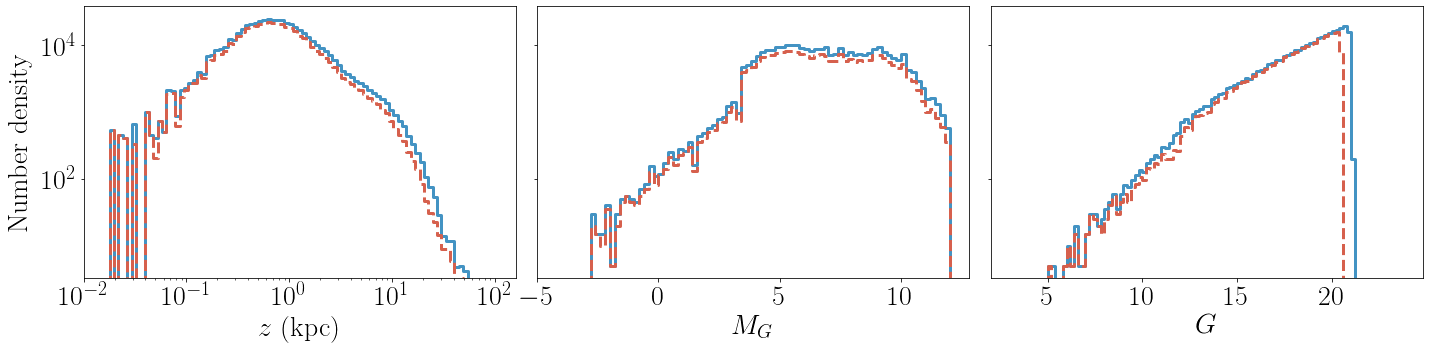

In [15]:
fig, axes = plt.subplots(1,3,figsize=(24,5), sharey=True)

full_kwargs = {'linewidth':3, 'c':cm.RdBu(0.8)}
sf_kwargs = {'linewidth':3, 'c':cm.RdBu(0.2), 'linestyle':'--'}

plt.sca(axes[0])
z_bins = np.logspace(-2,2.2,100)

hist, bins = np.histogram(sample[cardinal]['s']*sample[cardinal]['sinb'], bins=z_bins)
y = hist / (bins[1:]-bins[:-1])
plt.plot(np.repeat(bins,2), np.insert(np.repeat(y,2), (0,2*len(y)), (0,0)), **full_kwargs)

hist, bins = np.histogram((sample[cardinal]['s']*sample[cardinal]['sinb'])[sample[cardinal]['sf_subset']], bins=z_bins)
y = hist / (bins[1:]-bins[:-1])
plt.plot(np.repeat(bins,2), np.insert(np.repeat(y,2), (0,2*len(y)), (0,0)), **sf_kwargs)

plt.xscale('log'); plt.xlim(z_bins[0], z_bins[-1])
plt.ylabel(r'Number density', labelpad=10)
plt.xlabel(r'$z$ (kpc)');

plt.sca(axes[1])
M_bins = np.arange(-5,13,0.2)
hist, bins = np.histogram(sample[cardinal]['M'], bins=M_bins)
y = hist / (bins[1:]-bins[:-1])
plt.plot(np.repeat(bins,2), np.insert(np.repeat(y,2), (0,2*len(y)), (0,0)), **full_kwargs)

hist, bins = np.histogram(sample[cardinal]['M'][sample[cardinal]['sf_subset']], bins=M_bins)
y = hist / (bins[1:]-bins[:-1])
plt.plot(np.repeat(bins,2), np.insert(np.repeat(y,2), (0,2*len(y)), (0,0)), **sf_kwargs)

plt.xlim(M_bins[0], M_bins[-1])
plt.xlabel(r'$M_G$')


plt.sca(axes[2])
m_bins = np.arange(2,25,0.2)

hist, bins = np.histogram(sample[cardinal]['m'], bins=m_bins)
y = hist / (bins[1:]-bins[:-1])
plt.plot(np.repeat(bins,2), np.insert(np.repeat(y,2), (0,2*len(y)), (0,0)), **full_kwargs)

hist, bins = np.histogram(sample[cardinal]['m'][sample[cardinal]['sf_subset']], bins=m_bins)
y = hist / (bins[1:]-bins[:-1])
plt.plot(np.repeat(bins,2), np.insert(np.repeat(y,2), (0,2*len(y)), (0,0)), **sf_kwargs)

plt.xlim(m_bins[0], m_bins[-1])
plt.xlabel(r'$G$')

plt.subplots_adjust(wspace=0.05)
plt.yscale('log')

In [16]:
utils_dir = '/data/asfe2/Projects/mwtrace_data/utils/'
for cardinal in ['north', 'south']:
    model[cardinal]._generate_fid_pars(directory=utils_dir)
    model[cardinal].sample=sample[cardinal]
    
    model[cardinal+'_perr']._generate_fid_pars(directory=utils_dir)
    model[cardinal+'_perr'].sample=sample[cardinal]

directory:  /data/asfe2/Projects/mwtrace_data/utils/
Got Selectionfunction pars
directory:  /data/asfe2/Projects/mwtrace_data/utils/
Got Selectionfunction pars
directory:  /data/asfe2/Projects/mwtrace_data/utils/
Got Selectionfunction pars
directory:  /data/asfe2/Projects/mwtrace_data/utils/
Got Selectionfunction pars


# Plot results

In [17]:
ndim=np.sum([len(model['north'].free_pars[i]) for i in model['north'].free_pars]); 
plt.rc('axes', labelsize=ndim*3)
plt.rc('xtick',labelsize=ndim*3)
plt.rc('ytick',labelsize=ndim*3)
plt.rc('legend',fontsize=ndim*4)
plt.rc('font',size=ndim*3)

In [18]:
model['north']._generate_fid_pars(directory=utils_dir)
# for i in range(len(chains)): chains[i][:,:,[0,3,6]] = np.log10(chains[i][:,:,[0,3,6]])

index = ['North', 'South', r'North, $\sigma_\varpi$', r'South, $\sigma_\varpi$']
chains = [model['north'].mcmc_results['chain']['sf_mcmc'].copy(), 
          model['south'].mcmc_results['chain']['sf_mcmc'].copy(),
          model['north_perr'].mcmc_results['chain']['sf_perr_mcmc'].copy(), 
          model['south_perr'].mcmc_results['chain']['sf_perr_mcmc'].copy()]

functions = [model['north_perr'].fid_pars['functions'][j][par] for j in [0,1,2,'shd'] for par in model['north_perr'].free_pars[j]]
for i in [0,3,6]: functions[i] = lambda x: x/np.log(10)

labels = copy(transformations.label_set)
for i in [0,3,6]: labels[i] = '$\log_{10}(w)$'
    
for chain in chains:
    chain[:,:,[2,5,8]] *= -1

directory:  /data/asfe2/Projects/mwtrace_data/utils/
Got Selectionfunction pars


In [19]:
ndim=np.sum([len(model['north'].free_pars[i]) for i in model['north'].free_pars]); 
# plt.rc('axes', labelsize=ndim*5)
plt.rc('xtick',labelsize=ndim*4)
plt.rc('ytick',labelsize=ndim*4)
# plt.rc('legend',fontsize=ndim*5)
# plt.rc('font',size=ndim*5)

In [326]:
chains[0][:,2500:,4].flatten()

array([-3.16703928, -3.16703928, -3.16862185, ..., -2.92654274,
       -2.92654274, -2.92654274])

In [20]:
np.percentile(functions[4](chains[1][:,2500:,4].flatten()), (16,50,84)), \
np.percentile(functions[7](chains[3][:,2500:,7].flatten()), (16,50,84))

(array([0.77172455, 0.80216508, 0.83553628]),
 array([3.13677464, 3.24295711, 3.36941067]))

In [328]:
chains[0].shape

(44, 5000, 11)

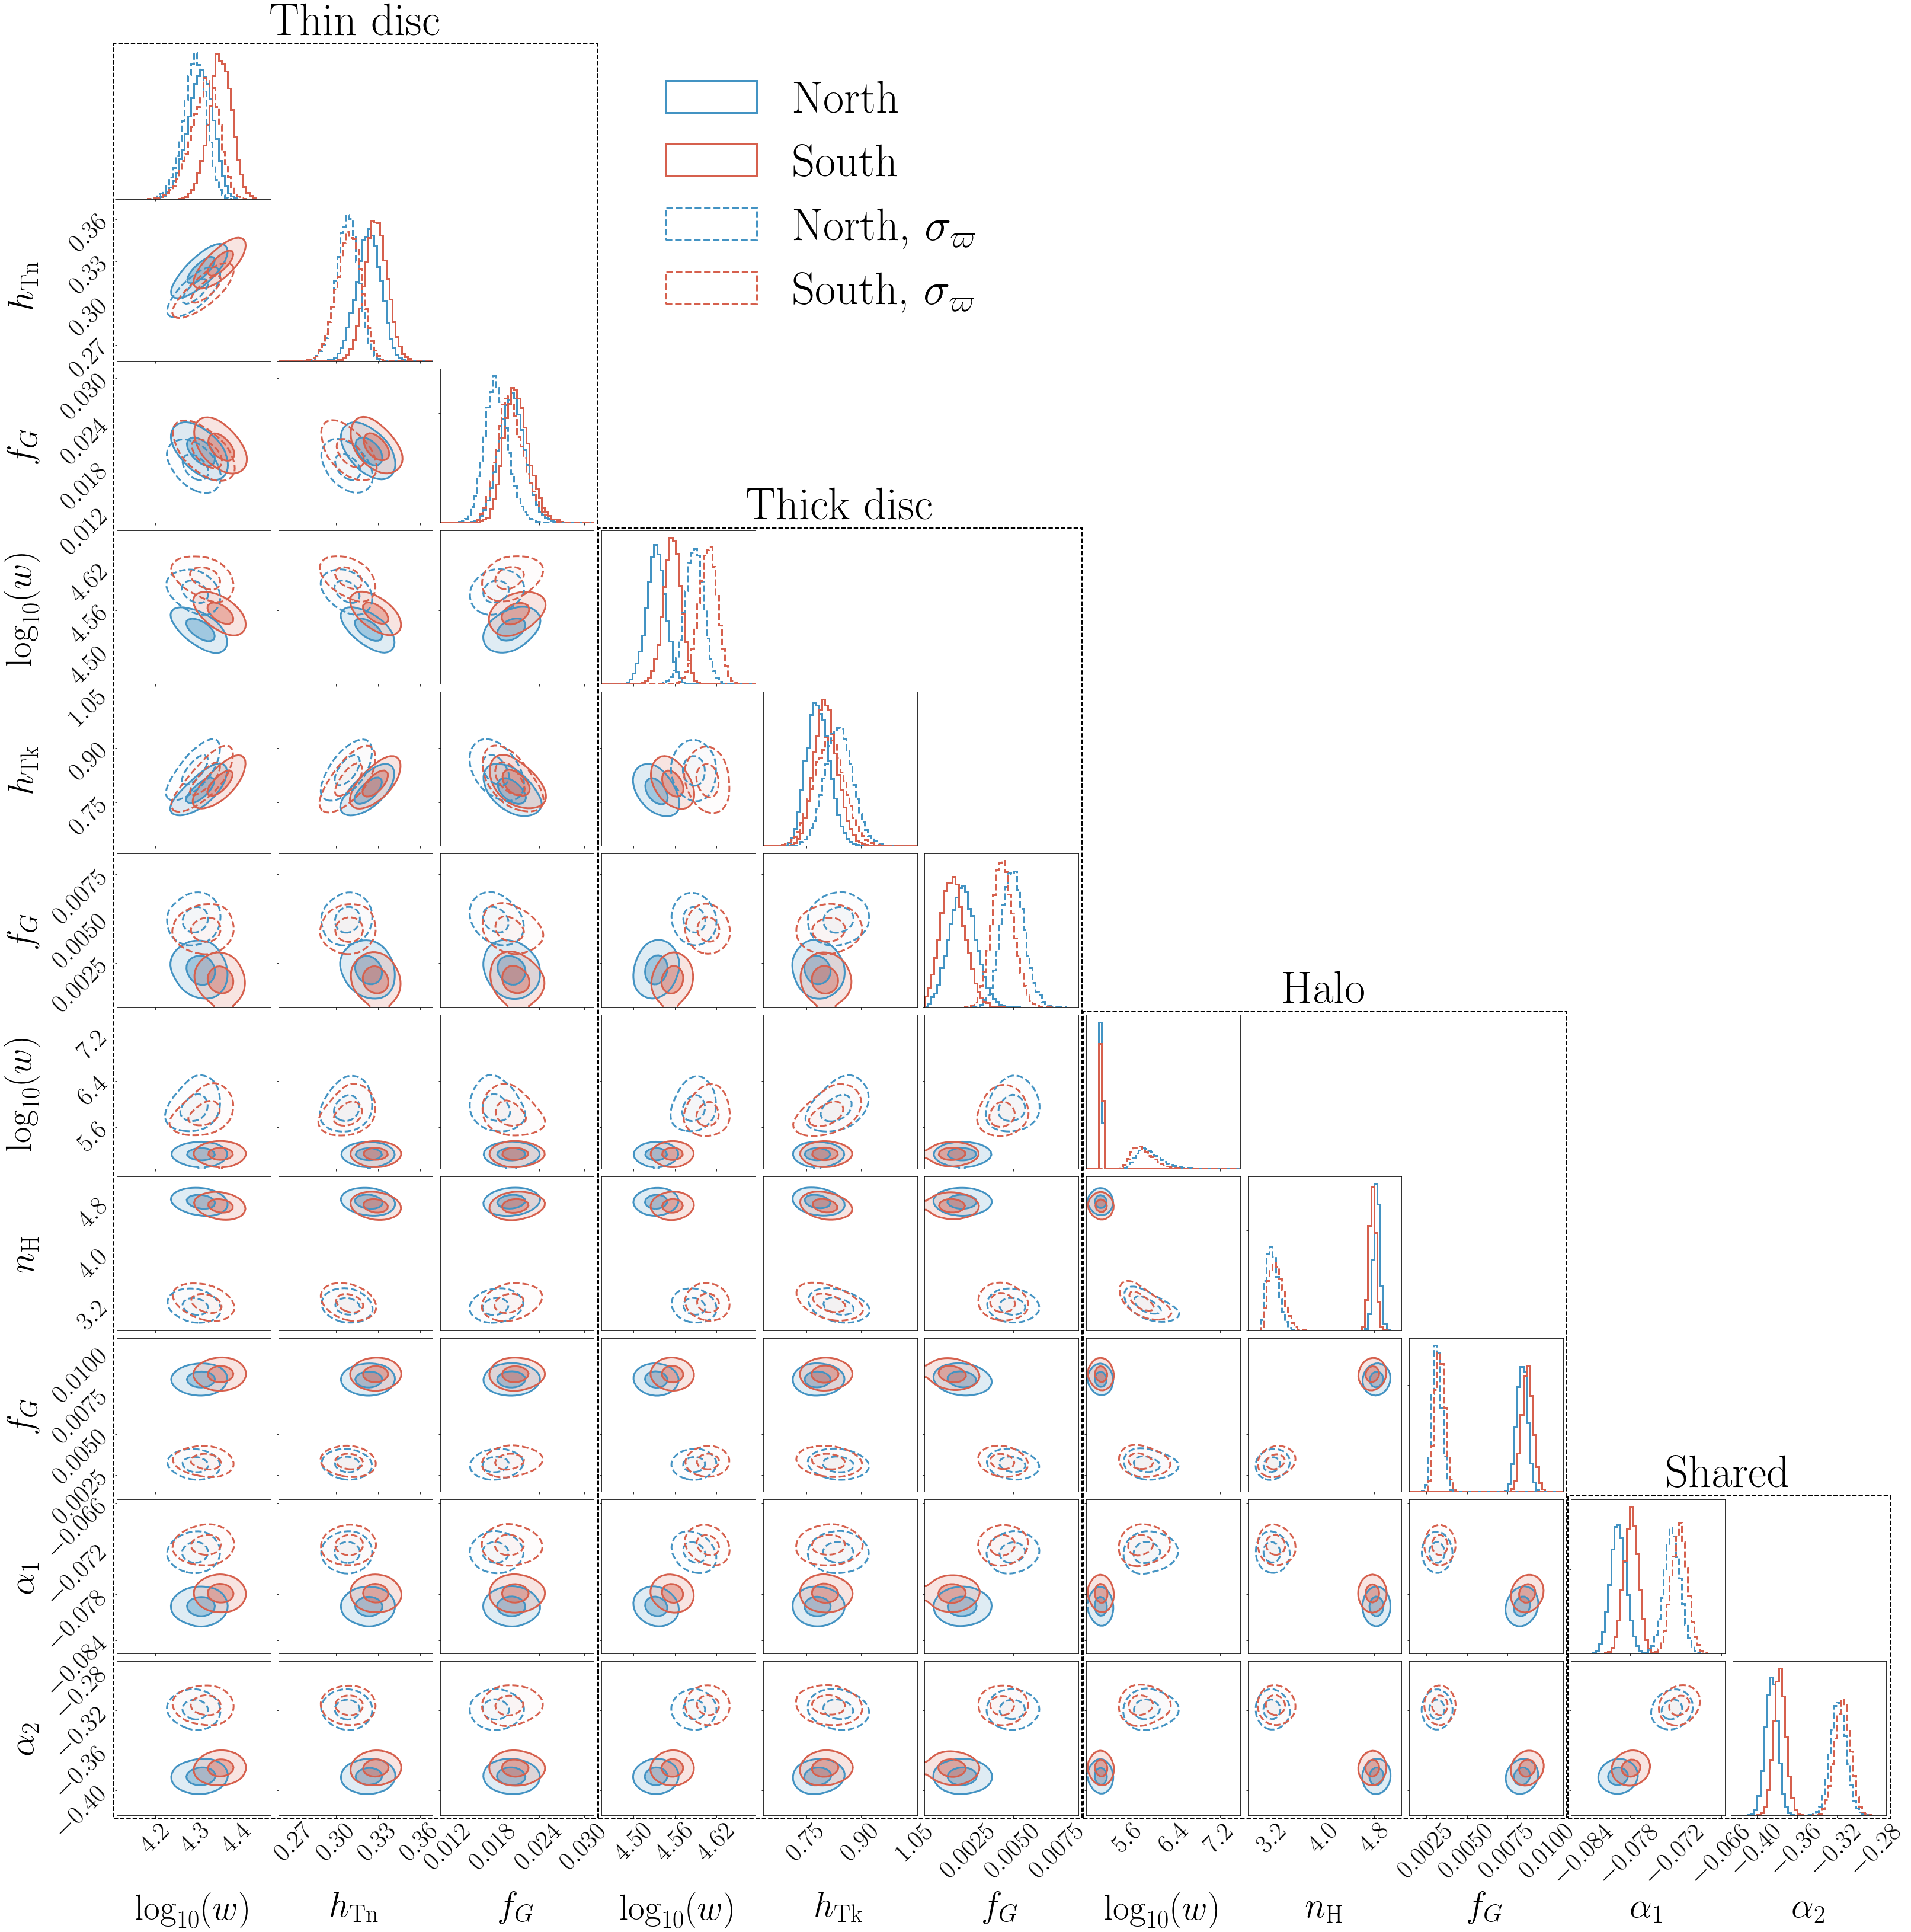

In [22]:
ndim=np.sum([len(model['north'].free_pars[i]) for i in model['north'].free_pars]); 
fig, axes = plt.subplots(ndim,ndim, figsize=(ndim*4,ndim*4))
# fig, axes = plt.subplots(3,3, figsize=(10,10))

rng = np.vstack((np.zeros(ndim)-np.inf, np.zeros(ndim)+np.inf)).T
rng[[2,5,8],0] = 0.; rng[[2,5,8],1] = 1. # fG
rng[7] = [2.-1e-10,7.3] # nH

plotting.layered_corners(chains, 
                         index=index, hist_kwargs={'linewidth':3}, contour_kwargs={'linewidths':3},
                         labels=labels, functions=functions, rng=rng,
                         linestyles=['-','-','--','--'], alphas=[1,1,0.1,0.1],
                         colors=[cm.RdBu(0.8), cm.RdBu(0.2), cm.RdBu(0.8), cm.RdBu(0.2)], 
                         fig=fig, ax=axes, 
                         label_kwargs={'fontsize':ndim*5.5, 'labelpad':20}, 
                        legend_kwargs={'fontsize':ndim*7, 'bbox_to_anchor':(3.3,-1.), 'loc':'lower left'})


npar = [len(model['north'].free_pars[i]) for i in model['north'].free_pars]
for jj, cmpt_label in enumerate(['Thin disc', 'Thick disc', 'Halo', 'Shared']):
    ## Boxed regions
    col = np.sum([0,]+npar[:jj])
    axrng = axes[ndim-1,col].axis()
    axdiff = (axrng[1]-axrng[0],axrng[3]-axrng[2])
    pad = 0.02
    rect = Rectangle((axrng[0]-pad*axdiff[0],axrng[2]-pad*axdiff[1]),
                    (1 + 2.4*pad)*npar[jj]*axdiff[0],
                    (1 + 2.4*pad)*(ndim-col)*axdiff[1], fill=False, edgecolor='k', alpha=1,lw=2,ls='--')
    rec = axes[ndim-1,col].add_patch(rect); rec.set_clip_on(False)
    
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()
    plt.sca(axes[ndim-1,col])
    plt.text(cx, cy, cmpt_label, ha='center', va='bottom', fontsize=7*ndim)
    #plt.text()
    
save_figs(f'figs/gums_{run_id:03d}_cornerf')

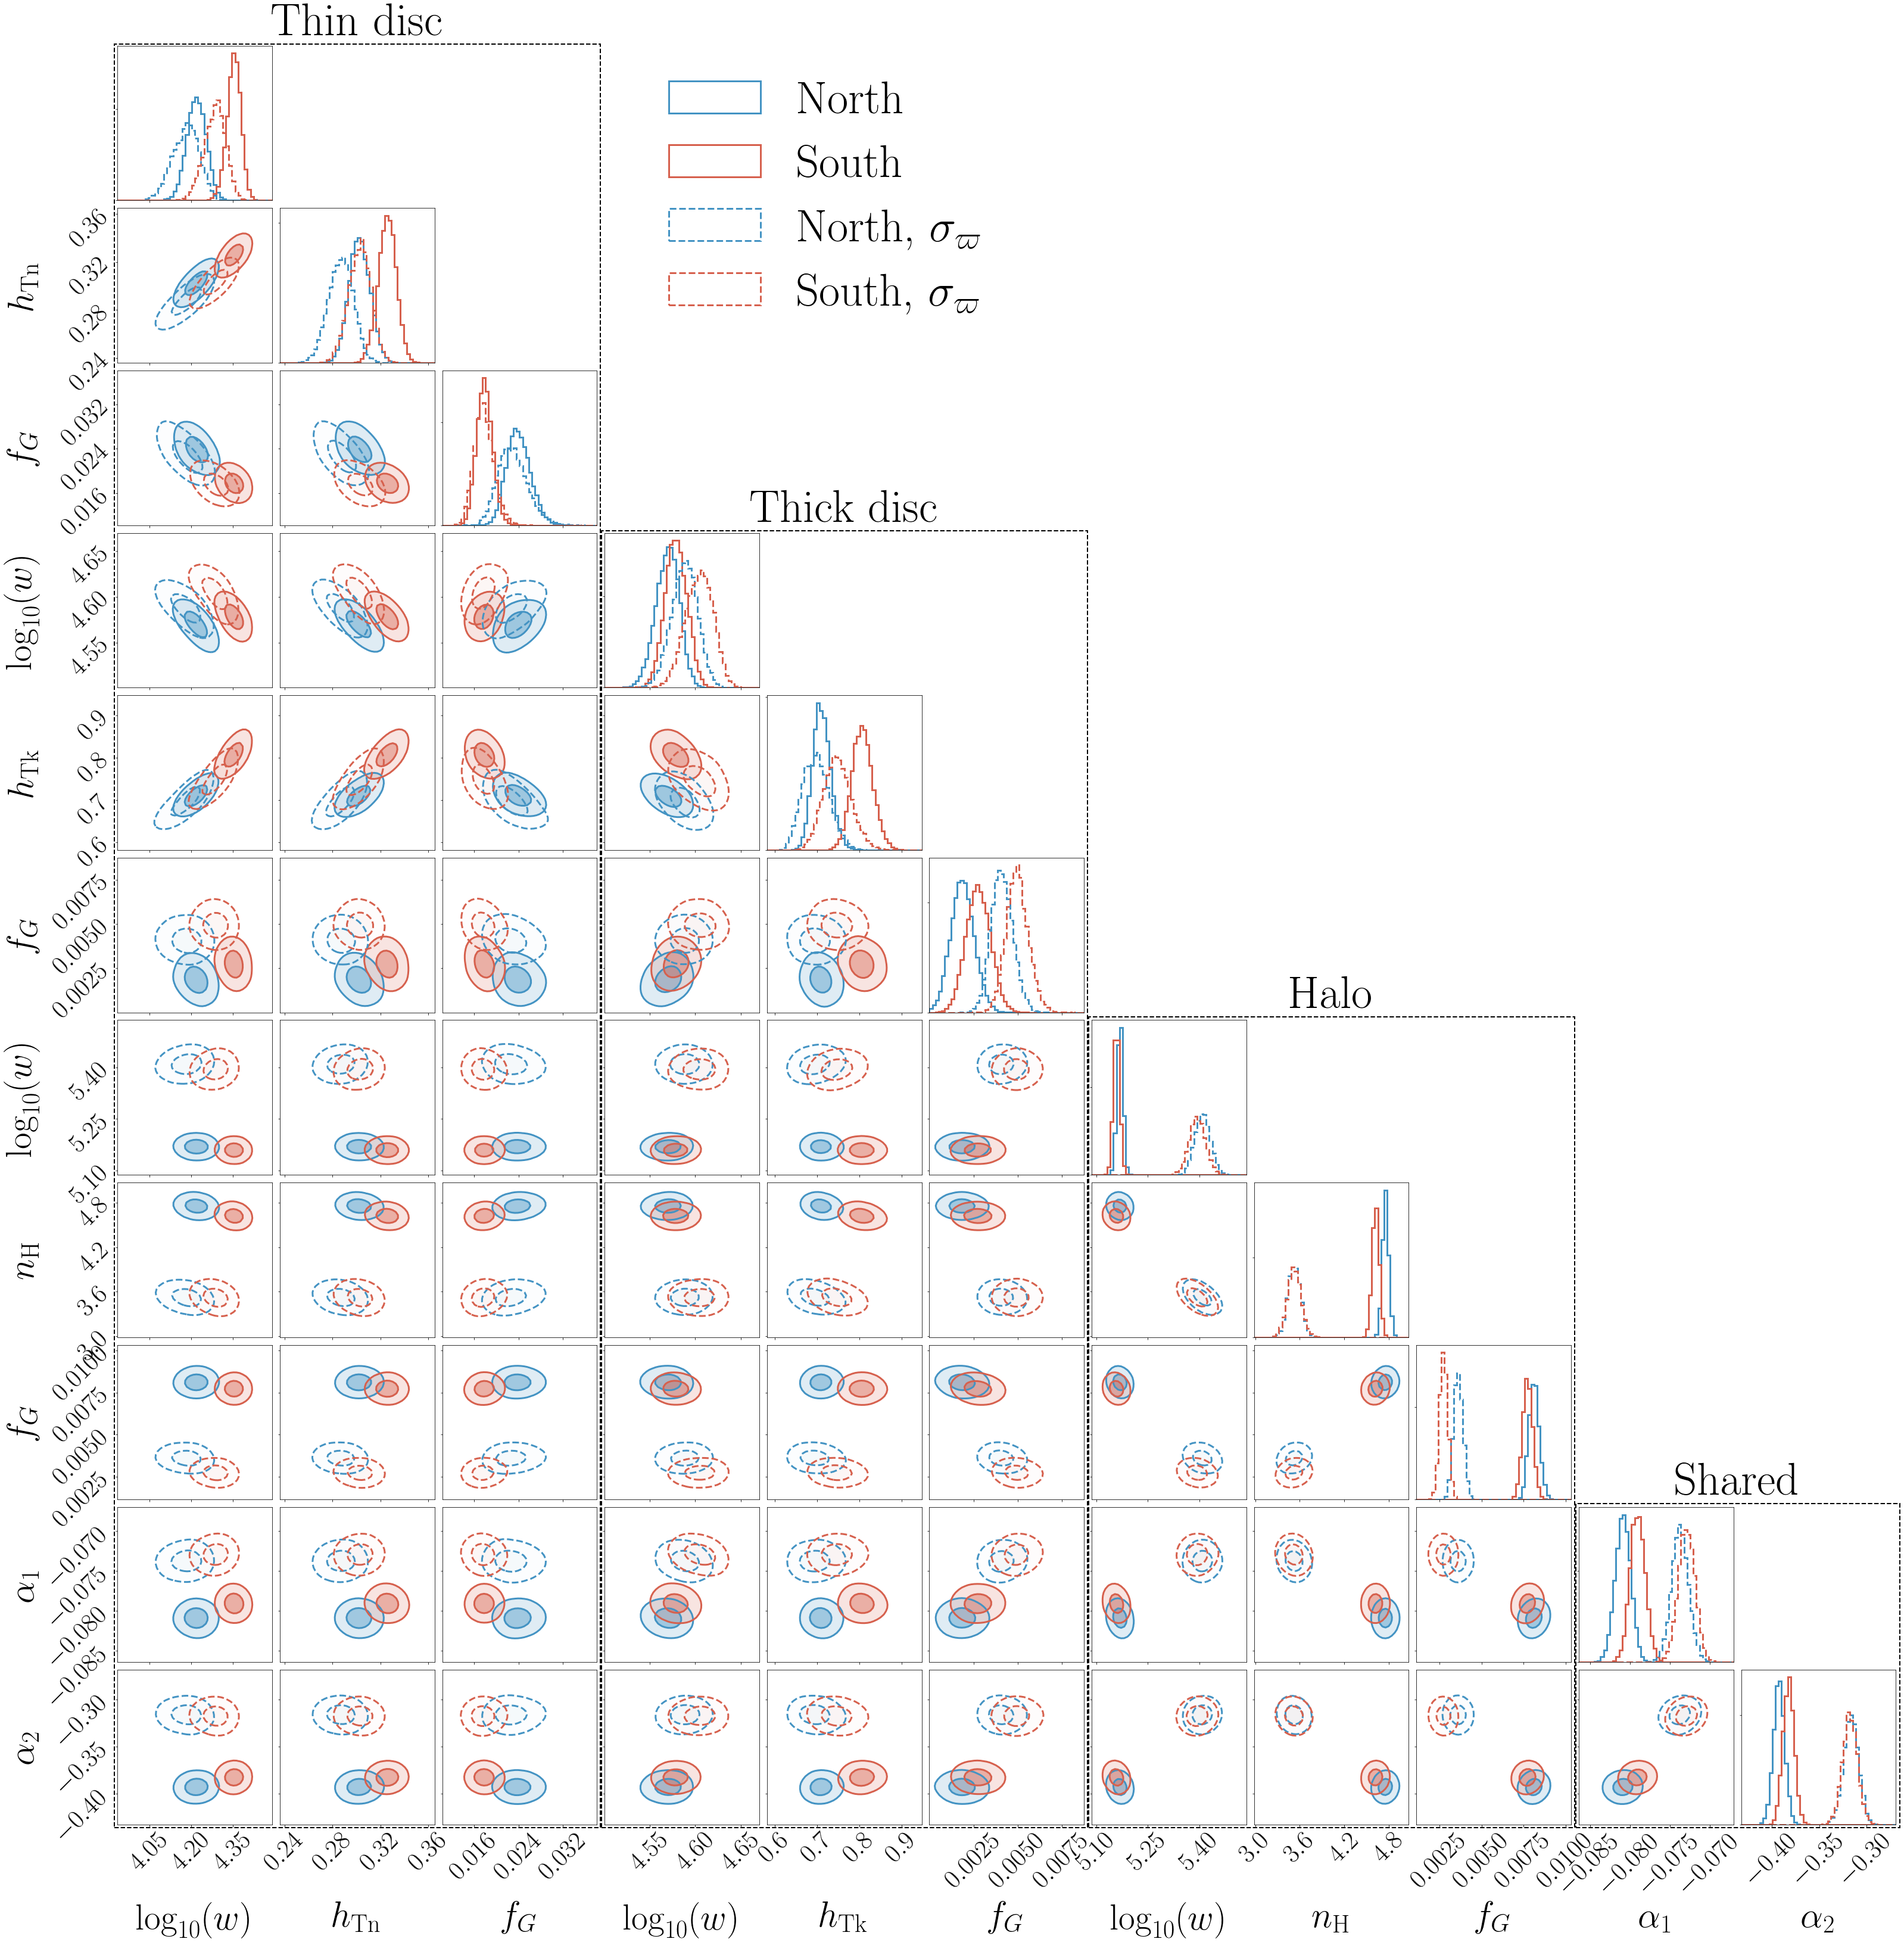

# Apparent magnitude

In [23]:
import tqdm.notebook

In [24]:
plt.rc('axes', labelsize=32)
plt.rc('xtick',labelsize=32)
plt.rc('ytick',labelsize=32)
plt.rc('legend',fontsize=32)
plt.rc('font',size=32)

In [25]:
# Get Gaia Selection Function
from selectionfunctions.carpentry import chisel
import selectionfunctions.cog_ii as CoGii
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/testselectionfunctions/'
#CoGii.fetch()
dr3_sf = CoGii.dr3_sf(version='modelAB',crowding=False)

Loading auxilliary data ...
Loading selection function ...
Creating selection function interpolator...
t = 4.450 s
  auxilliary:   4.446 s
          sf:   0.003 s
interpolator:   0.001 s
Loading auxilliary data ...


In [26]:
config['data_dir'] = '/data/asfe2/Projects/astrometry/PyOutput/'
M = 102; C = 1; jmax=5; lm=0.3; nside=64; ncores=88; B=2.0
map_fname = f"chisquare_ruwe1p4_jmax{jmax}_nside{nside}_M{M}_CGR{C}_lm{lm}lc200.0_B{B:.1f}_ncores{ncores}_scipy_results.h5"
ast_sf = chisel(map_fname=map_fname, nside=nside, C=C, M=M, lengthscale_m=lm, lengthscale_c=100.,
                basis_options={'needlet':'chisquare', 'j':jmax, 'B':B, 'p':1.0, 'wavelet_tol':1e-2},
                spherical_basis_directory='/data/asfe2/Projects/astrometry/SphericalWavelets/')

Loading auxilliary data ...
Spherical Basis: wavelet_chisquare_nside64_B2.0_p1.0_tol0.01_j[-1,0,1,2,3,4,5].h5


/home/andy/py37/lib/python3.7/site-packages/selectionfunctions/SelectionFunctionUtils.py:99: RuntimeWarning: overflow encountered in power
  u = l*(l+1) / np.power(self.B,2.0*j)


Spherical basis file loaded
t = 3.029 s
  auxilliary:   0.138 s
          sf:   0.000 s
interpolator:   2.890 s


In [27]:
ast_sf._g_max=20.5
gsf_pars = sf_utils.get_subgaiasf_pars(theta=model['north'].fid_pars['lat_min'], _nside=ast_sf.nside, 
                            dr2_sf=dr3_sf, sub_sf=ast_sf, _m_grid=np.arange(4.,30.1,0.2))

Higher Res:
Gaia SF:
Ast SF: (826, 131)


In [291]:
gsf_pars = sf_utils.get_subgaiasf_pars(theta=model['north'].fid_pars['lat_min'], _nside=ast_sf.nside, 
                            dr2_sf=dr3_sf, sub_sf=ast_sf, _m_grid=np.sort(np.insert(np.arange(4.,30.1,0.2), 0, ast_sf._g_max-1e-10)))

Higher Res:
Gaia SF:
Ast SF: (826, 132)


In [28]:
Nmag=500;

app_pars = {}
for key in ['uni_sinb_pixels', 'idx_sinb_pixels', 'pixel_area', 'pixel_id']:
    app_pars[key] = gsf_pars[key].copy()
    
mlim = [5,30]
app_pars['_selectionfunction'] = np.ones((gsf_pars['pixel_id'].size, Nmag))
app_pars['_m_grid'] = np.linspace(*mlim, Nmag)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/andy/py37/lib/python3.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in true_divide
/home/andy/py37/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in true_divide
/home/andy/py37/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: invalid value encountered in true_divide


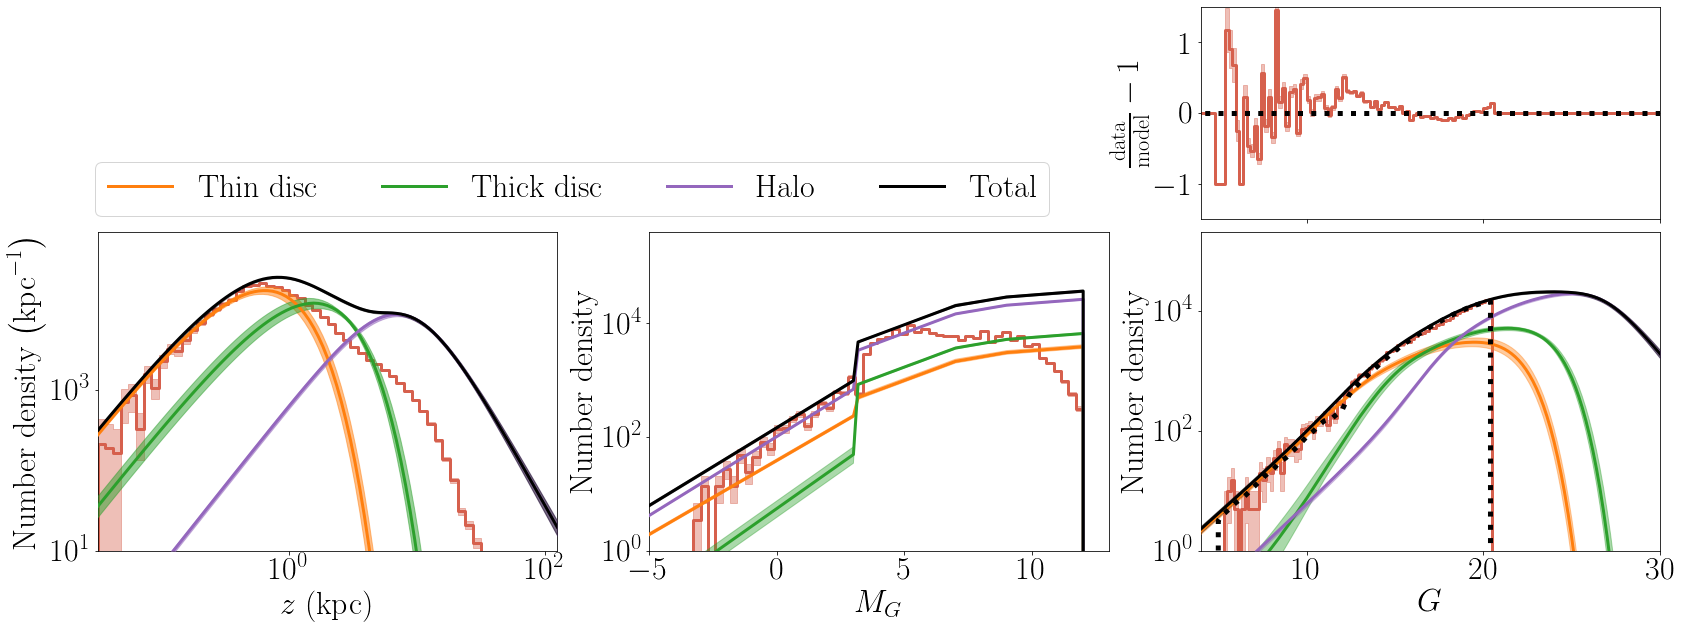

In [32]:
fig, axes = plt.subplots(2,3,figsize=(28,10), sharex='col', gridspec_kw={'height_ratios':[2,3]})


mcmc_kwargs = ({'c':'k','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:orange','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:green','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:purple','alpha':0.3, 'linestyle':':'})

mcmc_fill_kwargs = ({'color':'k', 'zorder':3}, 
                   {'color':'tab:orange', 'zorder':3}, 
                   {'color':'tab:green', 'zorder':3}, 
                   {'color':'tab:purple', 'zorder':3})

labels = ['Total', 'Thin disc', 'Thick disc', 'Halo']

extrap_kwargs = copy(mcmc_kwargs)
for i in range(4): extrap_kwargs[i]['alpha']=0.1


cardinal='north'; jj=1

nwalker, nstep, ndim = model[cardinal].mcmc_results['chain']['sf_mcmc'].shape
flat_chain = model[cardinal].mcmc_results['chain']['sf_mcmc'][:,int(nstep/2):].reshape(-1,ndim)
mcmc_samples = flat_chain[np.random.choice(np.arange(flat_chain.shape[0]), 100, replace=False)]


# VERTICAL HEIGHT
plt.sca(axes[jj,0])
zlim = (-1.5,2.1)
z_arr = np.logspace(zlim[0],zlim[1],101)

plotting.plot_hist((model[cardinal].sample['s']*model[cardinal].sample['sinb'])[model[cardinal].sample['sf_subset']], 
               np.logspace(zlim[0],zlim[1],61), ax=axes[jj,0], fill_poisson=True,
              plot_kwargs={'c':cm.RdBu(0.2), 'alpha':1, 'linewidth':3}, 
              fill_kwargs={'color':cm.RdBu(0.2),'alpha':0.4})

# posterior percentiles
fits_full = np.zeros((len(z_arr), mcmc_samples.shape[0]))
fits_cmpt = np.zeros((len(z_arr), 3, mcmc_samples.shape[0]))
for ii, mcmc_sample in enumerate(mcmc_samples):
    fits_full[:,ii] = dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal].fid_pars)
    fits_cmpt[:,:,ii] = dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal].fid_pars, model='all')
fits_full_pct = np.percentile(fits_full, (1, 16, 50, 84, 99), axis=1)
fits_cmpt_pct = np.percentile(fits_cmpt, (1, 16, 50, 84, 99), axis=2)
for i in range(3): 
    axes[jj,0].fill_between(z_arr, fits_cmpt_pct[0,:,i], fits_cmpt_pct[4,:,i], **mcmc_fill_kwargs[i+1],
                           alpha=0.5) 
    axes[jj,0].plot(z_arr, fits_cmpt_pct[2,:,i].T, **mcmc_fill_kwargs[i+1], alpha=1, linewidth=3, label=labels[i+1])
axes[jj,0].fill_between(z_arr, fits_full_pct[0], fits_full_pct[4], **mcmc_fill_kwargs[0], alpha=0.4)  
axes[jj,0].plot(z_arr,  fits_full_pct[2,:].T, **mcmc_fill_kwargs[0], alpha=1, linewidth=3, label=labels[0])  

plt.xlim(10**zlim[0],10**zlim[1])
plt.legend(loc='lower left', bbox_to_anchor=(-0.04,1.), ncol=4)#, fontsize=24)

plt.sca(axes[0,0]); plt.axis('off')
    
    
# ABSOLUTE MAGNITUDE
plt.sca(axes[jj,1])
fixed_mags = np.array([model['north'].fixed_pars[i] for i in ['Mms','Mms1','Mms2','Mx']])
M_arr = np.sort(np.hstack((np.linspace(-5.,13.,100), fixed_mags-1e-5, fixed_mags+1e-5)))


plotting.plot_hist(sample[cardinal]['M'][sample[cardinal]['sf_subset']], 
                   np.linspace(M_arr[0],model['north'].fixed_pars['Mx'],60), ax=axes[jj,1], fill_poisson=True,
              plot_kwargs={'c':cm.RdBu(0.2), 'alpha':1, 'linewidth':3}, 
              fill_kwargs={'color':cm.RdBu(0.2),'alpha':0.4})


fits_full = np.zeros((len(M_arr), mcmc_samples.shape[0]))
fits_cmpt = np.zeros((len(M_arr), 3, mcmc_samples.shape[0]))
for ii, mcmc_sample in enumerate(mcmc_samples):
    fits_full[:,ii] = dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model[cardinal].fid_pars)#, **mcmc_kwargs[0])    
    fits_cmpt[:,:,ii] = dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model[cardinal].fid_pars, model='all')
fits_full_pct = np.percentile(fits_full, (1, 16, 50, 84, 99), axis=1)
fits_cmpt_pct = np.percentile(fits_cmpt, (1, 16, 50, 84, 99), axis=2)
for i in range(3): 
    axes[jj,1].fill_between(M_arr, fits_cmpt_pct[1,:,i], fits_cmpt_pct[3,:,i], **mcmc_fill_kwargs[i+1],alpha=0.4) 
    axes[jj,1].plot(M_arr, fits_cmpt_pct[2,:,i].T, **mcmc_fill_kwargs[i+1],alpha=1, linewidth=3) 
axes[jj,1].fill_between(M_arr, fits_full_pct[0], fits_full_pct[4], **mcmc_fill_kwargs[0], alpha=0.4)  
axes[jj,1].plot(M_arr,fits_full_pct[2,:].T, **mcmc_fill_kwargs[0],alpha=1, linewidth=3) 

plt.sca(axes[0,1]); plt.axis('off')


# APPARENT MAGNITUDE
plt.sca(axes[jj,2])
model[cardinal].fid_pars['gsf_pars'] = gsf_pars
m_arr = model[cardinal].fid_pars['gsf_pars']['_m_grid'].copy()

plotting.plot_hist(sample[cardinal]['m'][sample[cardinal]['sf_subset']], 
                   np.arange(2.1,30.11,.2), ax=axes[jj,2], fill_poisson=True,
                   plot_kwargs={'c':cm.RdBu(0.2), 'alpha':1, 'linewidth':3}, 
                   fill_kwargs={'color':cm.RdBu(0.2),'alpha':0.4})

fits_cmpt = np.zeros((len(m_arr), 3, mcmc_samples.shape[0]))
fits_cmpt_sf = np.zeros((len(m_arr), 3, mcmc_samples.shape[0]))
for ii, mcmc_sample in tqdm.notebook.tqdm(enumerate(mcmc_samples), total=len(mcmc_samples)):  
    fits_cmpt[:,:,ii] = dh_msto.appmag_model_subgaiaSF(mcmc_sample, fid_pars=model[cardinal].fid_pars, sf=False).T
    fits_cmpt_sf[:,:,ii] = dh_msto.appmag_model_subgaiaSF(mcmc_sample, fid_pars=model[cardinal].fid_pars, sf=True).T
fits_full_pct = np.percentile(np.sum(fits_cmpt, axis=1), (1, 16, 50, 84, 99), axis=1)
fits_full_sf_pct = np.percentile(np.sum(fits_cmpt_sf, axis=1), (1, 16, 50, 84, 99), axis=1)
fits_cmpt_pct = np.percentile(fits_cmpt, (1, 16, 50, 84, 99), axis=2)
for i in range(3): 
    axes[1,2].fill_between(m_arr, fits_cmpt_pct[0,:,i], fits_cmpt_pct[4,:,i], **mcmc_fill_kwargs[i+1], alpha=0.4) 
    axes[1,2].plot(m_arr, fits_cmpt_pct[2,:,i].T, **mcmc_fill_kwargs[i+1],alpha=1, linewidth=3) 
axes[1,2].fill_between(m_arr, fits_full_pct[0], fits_full_pct[4], **mcmc_fill_kwargs[0], alpha=0.4)  
axes[1,2].plot(m_arr, fits_full_pct[2].T, **mcmc_fill_kwargs[0], alpha=1, linewidth=3)  
axes[1,2].plot(m_arr, fits_full_sf_pct[2].T, **mcmc_fill_kwargs[0], alpha=1, linewidth=5, linestyle=':')
    
m_bins = np.arange(2.,30.1,.2)
hist, bins = np.histogram(sample[cardinal]['m'][sample[cardinal]['sf_subset']], bins=m_bins)
m_interp = scipy.interpolate.interp1d(m_arr, fits_full_sf_pct[2], 
                                      bounds_error=False, fill_value=np.nan)((m_bins[1:]+m_bins[:-1])/2)
y = (hist/np.diff(bins) - m_interp)/m_interp; y[np.isnan(y)] = 0.
axes[0,2].plot( np.repeat(bins, 2), np.insert(np.repeat(y, 2), (0,2*len(y)), (0,0)), 
                c=cm.RdBu(0.2), alpha=1, linewidth=3)
y0 = y-np.sqrt(hist)/m_interp; y0[np.isnan(y0)] = 0.
y1 = y+np.sqrt(hist)/m_interp; y1[np.isnan(y1)] = 0.
axes[0,2].fill_between( np.repeat(bins, 2), np.insert(np.repeat(y0, 2), (0,2*len(y)), (0,0)), 
                                            np.insert(np.repeat(y1, 2), (0,2*len(y)), (0,0)), 
                color=cm.RdBu(0.2), alpha=0.4)
axes[0,2].plot([m_bins[0], m_bins[-1]], [0.,0.], ':k', linewidth=5)
    
    
plt.sca(axes[0,0]); plt.ylim(-1.5,1.5)
plt.sca(axes[1,0]); plt.xlabel(r'$z$ (kpc)'); 
plt.xscale('log'), plt.yscale('log'); plt.xlim(10**zlim[0], 10**zlim[1]), plt.ylim(10.,90000)
plt.ylabel(r'Number density $\left(\mathrm{kpc}^{-1}\right)$', labelpad=5)

plt.sca(axes[0,1]); plt.ylim(-1.5,1.5)
plt.sca(axes[1,1]); plt.xlabel(r'$M_G$')
plt.yscale('log'); plt.xlim(M_arr[0], M_arr[-1]); plt.ylim(1.,400000)
plt.ylabel(r'Number density', labelpad=5)

plt.sca(axes[0,2]);  plt.ylim(-1.5,1.5)
plt.ylabel(r'$\frac{\mathrm{data}}{\mathrm{model}} - 1$')
plt.sca(axes[1,2]); plt.xlabel(r'$G$')
plt.yscale('log'); plt.ylim(1.,200000); plt.xlim(m_arr[0], m_arr[-1]); 
plt.ylabel(r'Number density', labelpad=5)

plt.subplots_adjust(wspace=0.2, hspace=0.05)

save_figs(f'figs/gums_{cardinal}_{run_id:03d}_zMG_disthist')

  0%|          | 0/10 [00:00<?, ?it/s]

/home/andy/py37/lib/python3.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in true_divide
/home/andy/py37/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in true_divide
/home/andy/py37/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: invalid value encountered in true_divide


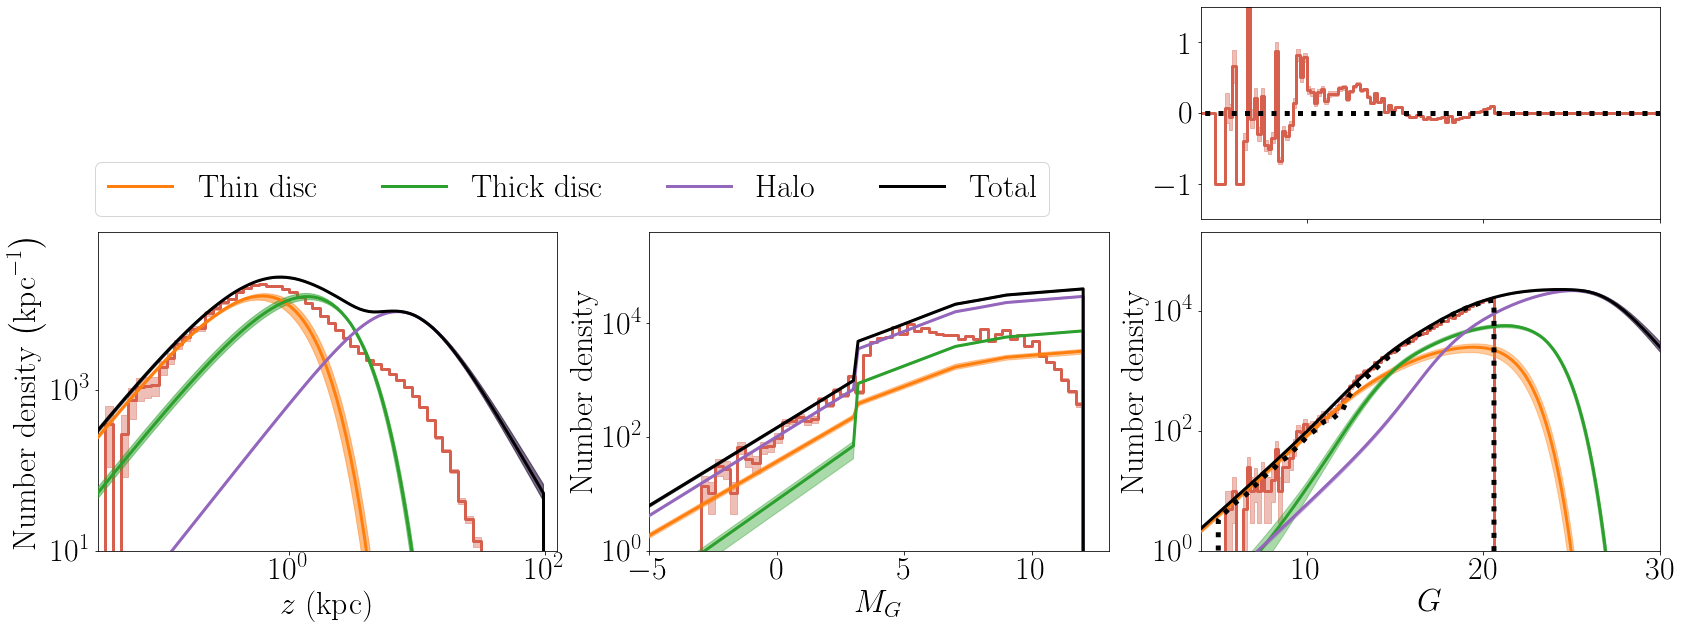

In [225]:
model[cardinal].sample['s']*model[cardinal].sample['sinb']

array([-4.04072571, -8.67277474, -4.55321703, ..., -6.68026413,
       -4.40201937, -4.47198569])

In [224]:
z_arr

array([3.16227766e-02, 3.43557948e-02, 3.73250158e-02, 4.05508535e-02,
       4.40554864e-02, 4.78630092e-02, 5.19995997e-02, 5.64936975e-02,
       6.13762005e-02, 6.66806769e-02, 7.24435960e-02, 7.87045790e-02,
       8.55066713e-02, 9.28966387e-02, 1.00925289e-01, 1.09647820e-01,
       1.19124201e-01, 1.29419584e-01, 1.40604752e-01, 1.52756606e-01,
       1.65958691e-01, 1.80301774e-01, 1.95884467e-01, 2.12813905e-01,
       2.31206479e-01, 2.51188643e-01, 2.72897778e-01, 2.96483139e-01,
       3.22106879e-01, 3.49945167e-01, 3.80189396e-01, 4.13047502e-01,
       4.48745390e-01, 4.87528490e-01, 5.29663444e-01, 5.75439937e-01,
       6.25172693e-01, 6.79203633e-01, 7.37904230e-01, 8.01678063e-01,
       8.70963590e-01, 9.46237161e-01, 1.02801630e+00, 1.11686325e+00,
       1.21338885e+00, 1.31825674e+00, 1.43218790e+00, 1.55596563e+00,
       1.69044093e+00, 1.83653834e+00, 1.99526231e+00, 2.16770410e+00,
       2.35504928e+00, 2.55858589e+00, 2.77971327e+00, 3.01995172e+00,
      

In [179]:
hist

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    1,    1,    2,    0,    0,
          1,    5,    2,    3,    2,    4,    2,    2,    3,   10,    2,
          5,    5,    7,   11,   20,   19,   26,   22,   24,   24,   31,
         36,   34,   38,   41,   46,   54,   67,   79,  109,  135,  160,
        171,  196,  205,  217,  277,  281,  336,  319,  395,  415,  479,
        534,  544,  580,  622,  684,  771,  822,  851,  956, 1015, 1097,
       1202, 1332, 1315, 1563, 1519, 1710, 1837, 1995, 2129, 2366, 2529,
       2632, 2783, 2965, 3110, 3240,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])

In [145]:
m_arr

array([ 4. ,  4.2,  4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,
        6.2,  6.4,  6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,
        8.4,  8.6,  8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2, 10.4,
       10.6, 10.8, 11. , 11.2, 11.4, 11.6, 11.8, 12. , 12.2, 12.4, 12.6,
       12.8, 13. , 13.2, 13.4, 13.6, 13.8, 14. , 14.2, 14.4, 14.6, 14.8,
       15. , 15.2, 15.4, 15.6, 15.8, 16. , 16.2, 16.4, 16.6, 16.8, 17. ,
       17.2, 17.4, 17.6, 17.8, 18. , 18.2, 18.4, 18.6, 18.8, 19. , 19.2,
       19.4, 19.6, 19.8, 20. , 20.2, 20.4, 20.6, 20.8, 21. , 21.2, 21.4,
       21.6, 21.8, 22. , 22.2, 22.4, 22.6, 22.8, 23. , 23.2, 23.4, 23.6,
       23.8, 24. , 24.2, 24.4, 24.6, 24.8, 25. , 25.2, 25.4, 25.6, 25.8,
       26. , 26.2, 26.4, 26.6, 26.8, 27. , 27.2, 27.4, 27.6, 27.8, 28. ,
       28.2, 28.4, 28.6, 28.8, 29. , 29.2, 29.4, 29.6, 29.8, 30. ])

In [153]:
m_arr

array([ 4. ,  4.2,  4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,
        6.2,  6.4,  6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,
        8.4,  8.6,  8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2, 10.4,
       10.6, 10.8, 11. , 11.2, 11.4, 11.6, 11.8, 12. , 12.2, 12.4, 12.6,
       12.8, 13. , 13.2, 13.4, 13.6, 13.8, 14. , 14.2, 14.4, 14.6, 14.8,
       15. , 15.2, 15.4, 15.6, 15.8, 16. , 16.2, 16.4, 16.6, 16.8, 17. ,
       17.2, 17.4, 17.6, 17.8, 18. , 18.2, 18.4, 18.6, 18.8, 19. , 19.2,
       19.4, 19.6, 19.8, 20. , 20.2, 20.4, 20.6, 20.8, 21. , 21.2, 21.4,
       21.6, 21.8, 22. , 22.2, 22.4, 22.6, 22.8, 23. , 23.2, 23.4, 23.6,
       23.8, 24. , 24.2, 24.4, 24.6, 24.8, 25. , 25.2, 25.4, 25.6, 25.8,
       26. , 26.2, 26.4, 26.6, 26.8, 27. , 27.2, 27.4, 27.6, 27.8, 28. ,
       28.2, 28.4, 28.6, 28.8, 29. , 29.2, 29.4, 29.6, 29.8, 30. ])

In [152]:
np.max(sample['north']['m'][sample[cardinal]['sf_subset']])

20.599982999999998

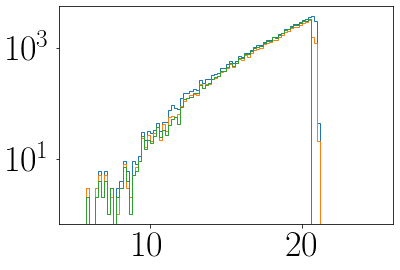

In [144]:
plt.hist(sample[cardinal]['m'],
         bins=np.arange(5,25.1,0.2), histtype='step');
plt.hist(sample[cardinal]['m'][sample[cardinal]['sf_subset']],
         bins=np.arange(5,25.1,0.2), histtype='step');
plt.hist(sample[cardinal]['m'][sample[cardinal]['astsf_subset']],
         bins=np.arange(5,25.1,0.2), histtype='step');
plt.yscale('log')

In [ ]:
np.max(sampo)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.050118723362727234, 71867.14360757502, 'North')

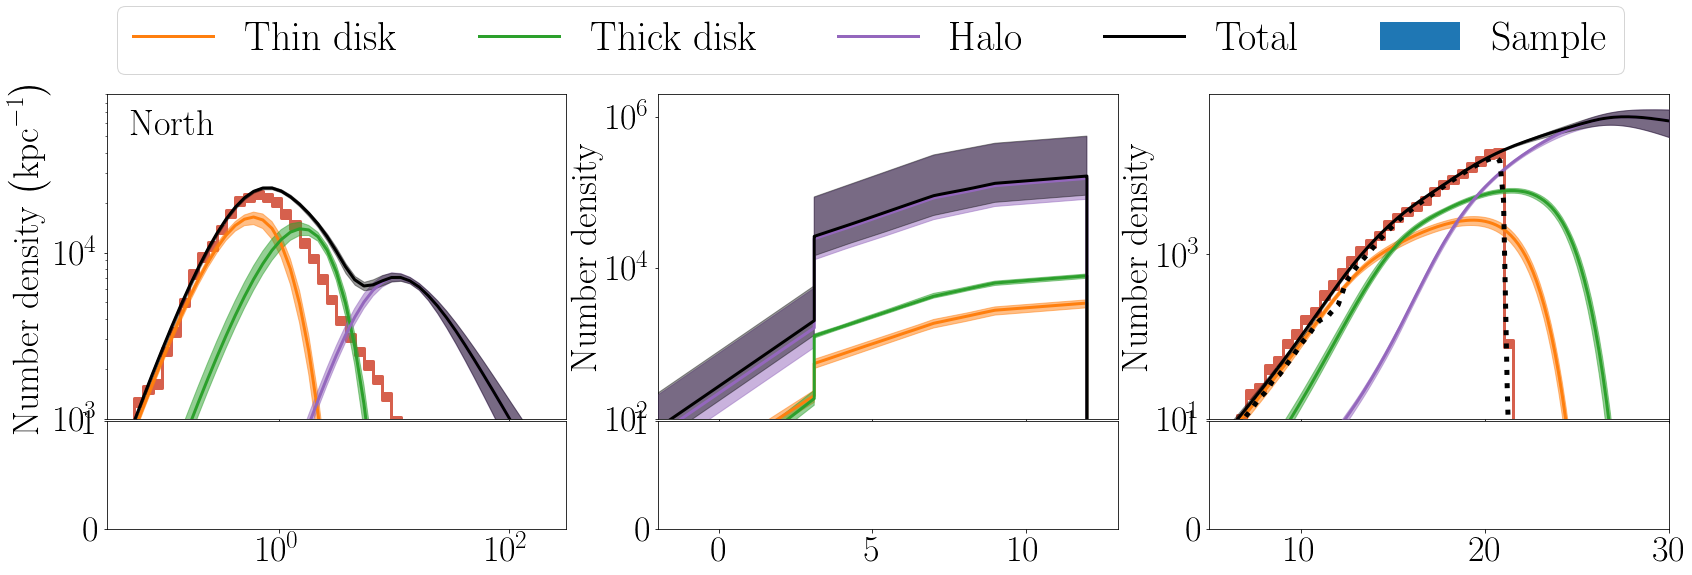

In [57]:
fig, axes = plt.subplots(2,3,figsize=(28,8), sharex='col', gridspec_kw={'height_ratios':[3,1]})


true_kwargs = ({'c':'k','alpha':1, 'linestyle':':', 'label':'Total', 'linewidth':4, 'zorder':4}, 
               {'c':'tab:orange','alpha':1, 'linestyle':':', 'label':'Thin disc', 'linewidth':4, 'zorder':4}, 
               {'c':'tab:green','alpha':1, 'linestyle':':', 'label':'Thick disc', 'linewidth':4, 'zorder':4}, 
               {'c':'tab:purple','alpha':1, 'linestyle':':', 'label':'Halo', 'linewidth':4, 'zorder':4})

mcmc_kwargs = ({'c':'k','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:orange','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:green','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:purple','alpha':0.3, 'linestyle':':'})
# mcmc_kwargs = ({'c':'k','linestyle':':', 'linewidth':2.}, 
#                {'c':'tab:orange','linestyle':':', 'linewidth':2.}, 
#                {'c':'tab:green','linestyle':':', 'linewidth':2.}, 
#                {'c':'tab:purple','linestyle':':', 'linewidth':2.})

mcmc_fill_kwargs = ({'color':'k', 'zorder':3}, 
                   {'color':'tab:orange', 'zorder':3}, 
                   {'color':'tab:green', 'zorder':3}, 
                   {'color':'tab:purple', 'zorder':3})

cardinal = 'north'
jj=0
if True:
    nwalker, nstep, ndim = model[cardinal+'_perr'].mcmc_results['chain']['sf_perr_mcmc'].shape
    flat_chain = model[cardinal+'_perr'].mcmc_results['chain']['sf_perr_mcmc'][:,int(nstep/2):].reshape(-1,ndim)
    mcmc_samples = flat_chain[np.random.choice(np.arange(flat_chain.shape[0]), 100, replace=False)]

    plt.sca(axes[jj,0])
    zlim = (-1.5,2.5)
    z_arr = np.logspace(zlim[0],zlim[1],51)

    # posterior percentiles
    fits_full = np.zeros((len(z_arr), mcmc_samples.shape[0]))
    fits_cmpt = np.zeros((len(z_arr), 3, mcmc_samples.shape[0]))
    for ii, mcmc_sample in enumerate(mcmc_samples):
        fits_full[:,ii] = dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal+'_perr'].fid_pars)
        fits_cmpt[:,:,ii] = dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal+'_perr'].fid_pars, model='all')
    fits_full_pct = np.percentile(fits_full, (1, 16, 50, 84, 99), axis=1)
    fits_cmpt_pct = np.percentile(fits_cmpt, (1, 16, 50, 84, 99), axis=2)
    for i in range(3): 
        axes[jj,0].fill_between(z_arr, fits_cmpt_pct[0,:,i], fits_cmpt_pct[4,:,i], **mcmc_fill_kwargs[i+1],
                               alpha=0.5) 
        axes[jj,0].plot(z_arr, fits_cmpt_pct[2,:,i].T, **mcmc_fill_kwargs[i+1], alpha=1, linewidth=3, label=labels[i+1])    
    axes[jj,0].fill_between(z_arr, fits_full_pct[0], fits_full_pct[4], **mcmc_fill_kwargs[0], alpha=0.4)  
    axes[jj,0].plot(z_arr,  fits_full_pct[2,:], **mcmc_fill_kwargs[0], alpha=1, linewidth=3, label=labels[0])  
        
    hist, bins = np.histogram(sample[cardinal]['s']*np.abs(sample[cardinal]['sinb']), bins=z_arr)
    x = np.repeat(bins,2)
    y = np.insert(np.repeat(hist/(bins[1:]-bins[:-1]),2), (0,2*len(hist)), (0,0))
    plt.plot(x, y, zorder=4, c=cm.RdBu(0.2), linewidth=1, alpha=0)
    plt.fill_between(x, y*0.95, y/0.95, zorder=0, color=cm.RdBu(0.2), linewidth=3, alpha=1, label='Sample')
    y0 = np.insert(np.repeat((hist-np.sqrt(hist))/(bins[1:]-bins[:-1]),2), (0,2*len(hist)), (0,0))
    y1 = np.insert(np.repeat((hist+np.sqrt(hist))/(bins[1:]-bins[:-1]),2), (0,2*len(hist)), (0,0))
    #plt.fill_between(x, y0, y1, zorder=0, color=cm.RdBu(0.1), alpha=0.5)

    plt.xlim(10**zlim[0],10**zlim[1])
    # if jj==0: plt.legend(loc='upper right')
    if jj==0: 
        leg = plt.legend(bbox_to_anchor=(-0.02,1.), loc='lower left', ncol=5, fontsize=40)
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
            lh.set_linewidth(3)
    
    
    plt.sca(axes[jj,1])
    fixed_mags = np.array([model[cardinal].fixed_pars['Mx'], model[cardinal].fixed_pars['Mms'], 
                           model[cardinal].fixed_pars['Mms1'], model[cardinal].fixed_pars['Mms2'],
                           model[cardinal].fixed_pars[0]['Mto'], 
                           model[cardinal].fixed_pars[1]['Mto'], 
                           model[cardinal].fixed_pars[2]['Mto']])
    M_arr = np.sort(np.hstack((np.linspace(-2.,13.,100), fixed_mags-1e-5, fixed_mags+1e-5)))

    # posterior percentiles
    fits_full = np.zeros((len(M_arr), mcmc_samples.shape[0]))
    fits_cmpt = np.zeros((len(M_arr), 3, mcmc_samples.shape[0]))
    for ii, mcmc_sample in enumerate(mcmc_samples):
        fits_full[:,ii] = dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model[cardinal].fid_pars)
        fits_cmpt[:,:,ii] = dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model[cardinal].fid_pars, model='all')
    fits_full_pct = np.percentile(fits_full, (1, 16, 50, 84, 99), axis=1)
    fits_cmpt_pct = np.percentile(fits_cmpt, (1, 16, 50, 84, 99), axis=2)
    for i in range(3): 
        axes[jj,1].fill_between(M_arr, fits_cmpt_pct[0,:,i], fits_cmpt_pct[4,:,i], **mcmc_fill_kwargs[i+1], alpha=0.5) 
        axes[jj,1].plot(M_arr, fits_cmpt_pct[2,:,i].T, **mcmc_fill_kwargs[i+1], alpha=1, linewidth=3, label=labels[i+1])    
    axes[jj,1].fill_between(M_arr, fits_full_pct[0], fits_full_pct[4], **mcmc_fill_kwargs[0], alpha=0.4)  
    axes[jj,1].plot(M_arr,  fits_full_pct[2,:], **mcmc_fill_kwargs[0], alpha=1, linewidth=3, label=labels[0])  
            
    plt.sca(axes[jj,2])
    model[cardinal].fid_pars['gsf_pars'] = gsf_pars
    m_arr = model[cardinal].fid_pars['gsf_pars']['_m_grid'].copy()

    # posterior percentiles
    fits_cmpt = np.zeros((len(m_arr), 3, mcmc_samples.shape[0]))
    fits_cmpt_nosf = np.zeros((len(m_arr), 3, mcmc_samples.shape[0]))
    for ii, mcmc_sample in tqdm.notebook.tqdm(enumerate(mcmc_samples), total=mcmc_samples.shape[0]):
        fits_cmpt[:,:,ii] = dh_msto.appmag_model_subgaiaSF(mcmc_sample, fid_pars=model[cardinal].fid_pars, sf=False).T
        fits_cmpt_nosf[:,:,ii] = dh_msto.appmag_model_subgaiaSF(mcmc_sample, fid_pars=model[cardinal].fid_pars, sf=True).T
    fits_full_pct = np.percentile(fits_cmpt.sum(axis=1), (1, 16, 50, 84, 99), axis=1)
    fits_cmpt_pct = np.percentile(fits_cmpt, (1, 16, 50, 84, 99), axis=2)
    fits_full_nosf_pct = np.percentile(fits_cmpt_nosf.sum(axis=1), (1, 16, 50, 84, 99), axis=1)
    fits_cmpt_nosf_pct = np.percentile(fits_cmpt_nosf, (1, 16, 50, 84, 99), axis=2)
    for i in range(3): 
        axes[jj,2].fill_between(m_arr, fits_cmpt_pct[0,:,i], fits_cmpt_pct[4,:,i], **mcmc_fill_kwargs[i+1], alpha=0.5) 
        axes[jj,2].plot(m_arr, fits_cmpt_pct[2,:,i].T, **mcmc_fill_kwargs[i+1], alpha=1, linewidth=3, label=labels[i+1])    
        # axes[jj,2].plot(m_arr, fits_cmpt_nosf_pct[2,:,i].T, **mcmc_fill_kwargs[i+1], alpha=1, linewidth=4, linestyle=':')
    axes[jj,2].fill_between(m_arr, fits_full_pct[0], fits_full_pct[4], **mcmc_fill_kwargs[0], alpha=0.4)  
    axes[jj,2].plot(m_arr,  fits_full_pct[2,:], **mcmc_fill_kwargs[0], alpha=1, linewidth=3, label=labels[0])
    axes[jj,2].plot(m_arr,  fits_full_nosf_pct[2,:], **mcmc_fill_kwargs[0], alpha=1, linewidth=5, linestyle=':')
            
            
    hist, bins = np.histogram(sample[cardinal]['m'], bins=np.arange(m_arr[0], m_arr[-1], 0.5))#m_arr)
    x = np.repeat(bins,2)
    y = np.insert(np.repeat(hist,2), (0,2*len(hist)), (0,0))/(bins[1]-bins[0])
    #plt.plot(x, y, zorder=4, c=cm.RdBu(0.1), linewidth=4, alpha=0.7)
    plt.fill_between(x, y*0.9, y/0.9, zorder=0, color=cm.RdBu(0.2), linewidth=3, alpha=1)
    y0 = np.insert(np.repeat(hist-np.sqrt(hist),2), (0,2*len(hist)), (0,0))/(bins[1]-bins[0])
    y1 = np.insert(np.repeat(hist+np.sqrt(hist),2), (0,2*len(hist)), (0,0))/(bins[1]-bins[0])
    #plt.fill_between(x, y0, y1, zorder=0, color=cm.RdBu(0.2), alpha=0.35)

plt.subplots_adjust(wspace=0.2, hspace=0.01)

plt.sca(axes[0,0])
plt.xscale('log'), plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); plt.ylim(1e3,9e4)
plt.ylabel(r'Number density $\left(\mathrm{kpc}^{-1}\right)$')
plt.sca(axes[0,1])
plt.yscale('log'); plt.xlabel(r'$M_G$'); plt.xlim(M_arr[0], M_arr[-1]); plt.ylim(1e2,2e6)
plt.ylabel(r'Number density')
plt.sca(axes[0,2]); plt.yscale('log'); plt.xlabel(r'$G$'); plt.xlim(mlim); plt.ylim(1e1,9e4)
plt.ylabel(r'Number density')


ax = axes[0,0]
plt.sca(ax)
plt.text(ax.get_xlim()[0]**0.95 * ax.get_xlim()[1]**0.05,
         ax.get_ylim()[0]**0.05 * ax.get_ylim()[1]**0.95, clabels[cardinal],
        ha='left', va='top')

In [ ]:
true_kwargs = ({'c':'k','alpha':1, 'linestyle':':', 'label':'Total', 'linewidth':4, 'zorder':4}, 
               {'c':'tab:orange','alpha':1, 'linestyle':':', 'label':'Thin disc', 'linewidth':4, 'zorder':4}, 
               {'c':'tab:green','alpha':1, 'linestyle':':', 'label':'Thick disc', 'linewidth':4, 'zorder':4}, 
               {'c':'tab:purple','alpha':1, 'linestyle':':', 'label':'Halo', 'linewidth':4, 'zorder':4})

mcmc_kwargs = ({'c':'k','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:orange','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:green','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:purple','alpha':0.3, 'linestyle':':'})
# mcmc_kwargs = ({'c':'k','linestyle':':', 'linewidth':2.}, 
#                {'c':'tab:orange','linestyle':':', 'linewidth':2.}, 
#                {'c':'tab:green','linestyle':':', 'linewidth':2.}, 
#                {'c':'tab:purple','linestyle':':', 'linewidth':2.})

mcmc_fill_kwargs = ({'color':'k', 'zorder':3}, 
                   {'color':'tab:orange', 'zorder':3}, 
                   {'color':'tab:green', 'zorder':3}, 
                   {'color':'tab:purple', 'zorder':3})

cardinal = 'north'

nwalker, nstep, ndim = model[cardinal+'_perr'].mcmc_results['chain']['sf_perr_mcmc'].shape
flat_chain = model[cardinal+'_perr'].mcmc_results['chain']['sf_perr_mcmc'][:,int(nstep/2):].reshape(-1,ndim)
mcmc_samples = flat_chain[np.random.choice(np.arange(flat_chain.shape[0]), 10, replace=False)]

In [72]:
zlim = (-1.5,2.5)
z_arr = np.logspace(zlim[0],zlim[1],51)

fixed_mags = np.array([model[cardinal].fixed_pars['Mx'], model[cardinal].fixed_pars['Mms'], 
                       model[cardinal].fixed_pars['Mms1'], model[cardinal].fixed_pars['Mms2'],
                       model[cardinal].fixed_pars[0]['Mto'], 
                       model[cardinal].fixed_pars[1]['Mto'], 
                       model[cardinal].fixed_pars[2]['Mto']])
M_arr = np.sort(np.hstack((np.linspace(-2.,13.,100), fixed_mags-1e-5, fixed_mags+1e-5)))

zz, MM = np.meshgrid(z_arr, M_arr)
mm = MM + 10 - 2.5*np.log10(zz)

zM_gsf_pars = sf_utils.get_subgaiasf_pars(theta=np.deg2rad(80), _nside=ast_sf.nside, 
                                          dr2_sf=dr3_sf, sub_sf=ast_sf, _m_grid=mm.flatten())

Higher Res:
Gaia SF:
Ast SF: (826, 5814)


In [ ]:
dh_msto.appmag_model_subgaiaSF(mcmc_sample, fid_pars=model[cardinal].fid_pars, gsf_pars=zM_gsf_pars, sf=False).T

In [80]:
mm.shape

(114, 51)

In [81]:
fits_cmpt_sf = np.zeros((len(mm.flatten()), 3, mcmc_samples.shape[0]))
for ii, mcmc_sample in tqdm.notebook.tqdm(enumerate(mcmc_samples), total=mcmc_samples.shape[0]):
    fits_cmpt_sf[:,:,ii] = dh_msto.appmag_model_subgaiaSF(mcmc_sample, fid_pars=model[cardinal].fid_pars, gsf_pars=zM_gsf_pars, sf=True).T
zM_cmpt_sf = fits_cmpt_sf.reshape(mm.shape+fits_cmpt_sf.shape[1:])    

  0%|          | 0/100 [00:00<?, ?it/s]

In [87]:
zM_cmpt_sf.shape

(114, 51, 3, 100)

In [91]:
z_arr.diff

AttributeError: 'numpy.ndarray' object has no attribute 'diff'

In [94]:
z_cmpt_sf

array([[[14287.2200125 , 13790.47728587, 14743.62515719, ...,
         14022.08358594, 13650.09521522, 13610.59806935],
        [21294.73310915, 21485.48555157, 20202.95646784, ...,
         21170.67827431, 20566.110982  , 21650.01373044],
        [16092.72403566, 16340.07480132, 16377.212497  , ...,
         16250.27712057, 17185.23861651, 16435.866645  ]],

       [[14239.75651797, 13745.44393073, 14692.14462146, ...,
         13973.44743094, 13605.94066929, 13565.2095021 ],
        [21084.45072262, 21274.66002018, 20005.02935427, ...,
         20962.17686782, 20371.10238685, 21440.08567692],
        [15708.54938666, 15954.10875287, 15985.08897569, ...,
         15869.39714981, 16784.24033265, 16053.26912442]],

       [[14251.11302193, 13756.60775403, 14702.00574325, ...,
         13982.90726113, 13617.43776004, 13575.91408841],
        [21053.04077962, 21243.53452818, 19976.21404683, ...,
         20931.29147733, 20342.60770581, 21409.55587056],
        [15666.60091769, 15911.71151

In [75]:
fits_cmpt_nosf = np.zeros(zz.shape + (3, mcmc_samples.shape[0]))
for ii, mcmc_sample in tqdm.notebook.tqdm(enumerate(mcmc_samples), total=mcmc_samples.shape[0]):
    fits_cmpt[:,:,ii] = dh_msto.appmag_model_subgaiaSF(mcmc_sample, fid_pars=model[cardinal].fid_pars, sf=False).T
fits_full_pct = np.percentile(fits_cmpt.sum(axis=1), (1, 16, 50, 84, 99), axis=1)
fits_cmpt_pct = np.percentile(fits_cmpt, (1, 16, 50, 84, 99), axis=2)
fits_full_nosf_pct = np.percentile(fits_cmpt_nosf.sum(axis=1), (1, 16, 50, 84, 99), axis=1)
fits_cmpt_nosf_pct = np.percentile(fits_cmpt_nosf, (1, 16, 50, 84, 99), axis=2)
for i in range(3): 
    axes[jj,2].fill_between(m_arr, fits_cmpt_pct[0,:,i], fits_cmpt_pct[4,:,i], **mcmc_fill_kwargs[i+1], alpha=0.5) 
    axes[jj,2].plot(m_arr, fits_cmpt_pct[2,:,i].T, **mcmc_fill_kwargs[i+1], alpha=1, linewidth=3, label=labels[i+1])    
    # axes[jj,2].plot(m_arr, fits_cmpt_nosf_pct[2,:,i].T, **mcmc_fill_kwargs[i+1], alpha=1, linewidth=4, linestyle=':')
axes[jj,2].fill_between(m_arr, fits_full_pct[0], fits_full_pct[4], **mcmc_fill_kwargs[0], alpha=0.4)  
axes[jj,2].plot(m_arr,  fits_full_pct[2,:], **mcmc_fill_kwargs[0], alpha=1, linewidth=3, label=labels[0])
axes[jj,2].plot(m_arr,  fits_full_nosf_pct[2,:], **mcmc_fill_kwargs[0], alpha=1, linewidth=5, linestyle=':')

(100, 11)

Text(0.050118723362727234, 71867.14360757502, 'North')

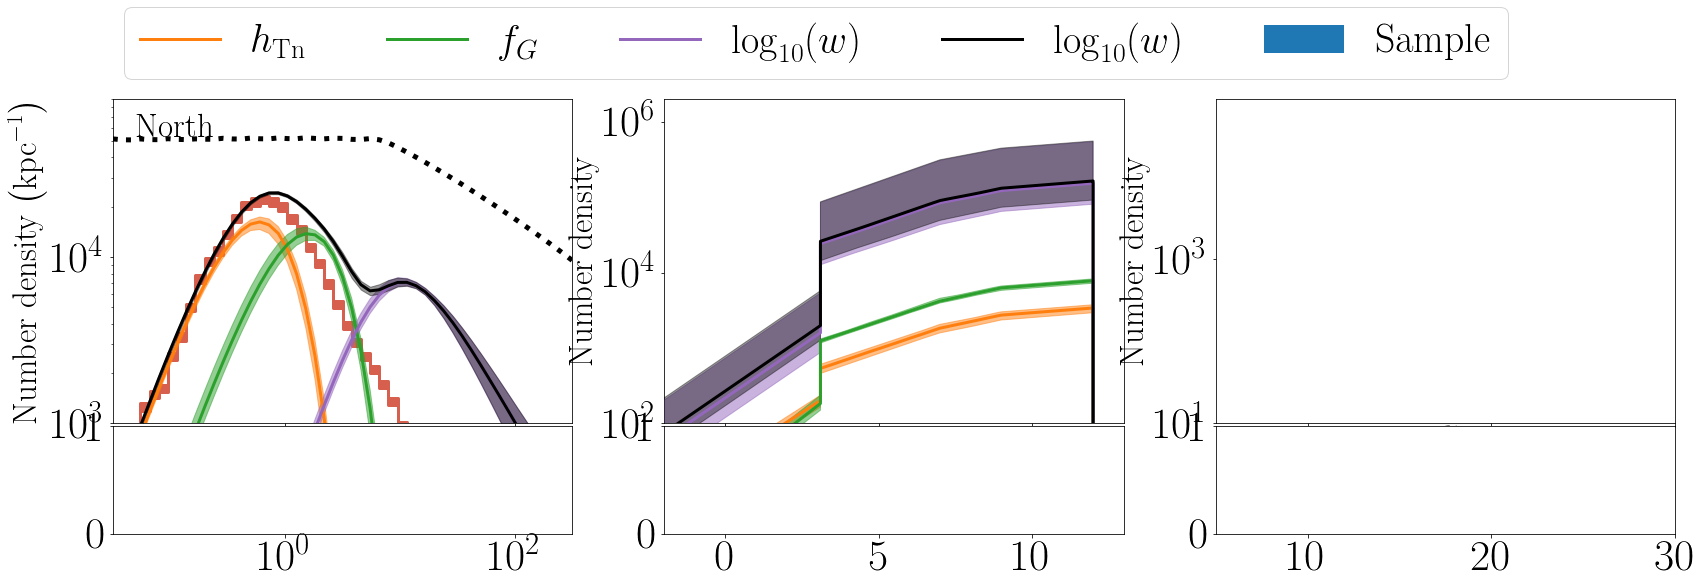

In [104]:
fig, axes = plt.subplots(2,3,figsize=(28,8), sharex='col', gridspec_kw={'height_ratios':[3,1]})

jj=0
plt.sca(axes[jj,0])
# posterior percentiles
fits_full = np.zeros((len(z_arr), mcmc_samples.shape[0]))
fits_cmpt = np.zeros((len(z_arr), 3, mcmc_samples.shape[0]))
for ii, mcmc_sample in enumerate(mcmc_samples):
    fits_full[:,ii] = dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal+'_perr'].fid_pars)
    fits_cmpt[:,:,ii] = dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal+'_perr'].fid_pars, model='all')
fits_full_pct = np.percentile(fits_full, (1, 16, 50, 84, 99), axis=1)
fits_cmpt_pct = np.percentile(fits_cmpt, (1, 16, 50, 84, 99), axis=2)
for i in range(3): 
    axes[jj,0].fill_between(z_arr, fits_cmpt_pct[0,:,i], fits_cmpt_pct[4,:,i], **mcmc_fill_kwargs[i+1],
                           alpha=0.5) 
    axes[jj,0].plot(z_arr, fits_cmpt_pct[2,:,i].T, **mcmc_fill_kwargs[i+1], alpha=1, linewidth=3, label=labels[i+1])    
axes[jj,0].fill_between(z_arr, fits_full_pct[0], fits_full_pct[4], **mcmc_fill_kwargs[0], alpha=0.4)  
axes[jj,0].plot(z_arr,  fits_full_pct[2,:], **mcmc_fill_kwargs[0], alpha=1, linewidth=3, label=labels[0])  

hist, bins = np.histogram(sample[cardinal]['s']*np.abs(sample[cardinal]['sinb']), bins=z_arr)
x = np.repeat(bins,2)
y = np.insert(np.repeat(hist/(bins[1:]-bins[:-1]),2), (0,2*len(hist)), (0,0))
plt.plot(x, y, zorder=4, c=cm.RdBu(0.2), linewidth=1, alpha=0)
plt.fill_between(x, y*0.95, y/0.95, zorder=0, color=cm.RdBu(0.2), linewidth=3, alpha=1, label='Sample')
y0 = np.insert(np.repeat((hist-np.sqrt(hist))/(bins[1:]-bins[:-1]),2), (0,2*len(hist)), (0,0))
y1 = np.insert(np.repeat((hist+np.sqrt(hist))/(bins[1:]-bins[:-1]),2), (0,2*len(hist)), (0,0))
#plt.fill_between(x, y0, y1, zorder=0, color=cm.RdBu(0.1), alpha=0.5)

plt.xlim(10**zlim[0],10**zlim[1])
# if jj==0: plt.legend(loc='upper right')
if jj==0: 
    leg = plt.legend(bbox_to_anchor=(-0.02,1.), loc='lower left', ncol=5, fontsize=40)
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
        lh.set_linewidth(3)

z_cmpt_sf = np.sum((zM_cmpt_sf[1:]+zM_cmpt_sf[:-1])/2 * np.diff(M_arr)[:,None,None,None], axis=(0))
z_cmpt_sf_pct = np.percentile(z_cmpt_sf.sum(axis=1), (1, 16, 50, 84, 99), axis=1)
axes[jj,0].plot(z_arr,  z_cmpt_sf_pct[2,:], **mcmc_fill_kwargs[0], alpha=1, linewidth=5, linestyle=':')        


plt.sca(axes[jj,1])
# posterior percentiles
fits_full = np.zeros((len(M_arr), mcmc_samples.shape[0]))
fits_cmpt = np.zeros((len(M_arr), 3, mcmc_samples.shape[0]))
for ii, mcmc_sample in enumerate(mcmc_samples):
    fits_full[:,ii] = dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model[cardinal].fid_pars)
    fits_cmpt[:,:,ii] = dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model[cardinal].fid_pars, model='all')
fits_full_pct = np.percentile(fits_full, (1, 16, 50, 84, 99), axis=1)
fits_cmpt_pct = np.percentile(fits_cmpt, (1, 16, 50, 84, 99), axis=2)
for i in range(3): 
    axes[jj,1].fill_between(M_arr, fits_cmpt_pct[0,:,i], fits_cmpt_pct[4,:,i], **mcmc_fill_kwargs[i+1], alpha=0.5) 
    axes[jj,1].plot(M_arr, fits_cmpt_pct[2,:,i].T, **mcmc_fill_kwargs[i+1], alpha=1, linewidth=3, label=labels[i+1])    
axes[jj,1].fill_between(M_arr, fits_full_pct[0], fits_full_pct[4], **mcmc_fill_kwargs[0], alpha=0.4)  
axes[jj,1].plot(M_arr,  fits_full_pct[2,:], **mcmc_fill_kwargs[0], alpha=1, linewidth=3, label=labels[0])  



# plt.sca(axes[jj,2])
# model[cardinal].fid_pars['gsf_pars'] = gsf_pars
# m_arr = model[cardinal].fid_pars['gsf_pars']['_m_grid'].copy()

# # posterior percentiles
# fits_cmpt = np.zeros((len(m_arr), 3, mcmc_samples.shape[0]))
# fits_cmpt_nosf = np.zeros((len(m_arr), 3, mcmc_samples.shape[0]))
# for ii, mcmc_sample in tqdm.notebook.tqdm(enumerate(mcmc_samples), total=mcmc_samples.shape[0]):
#     fits_cmpt[:,:,ii] = dh_msto.appmag_model_subgaiaSF(mcmc_sample, fid_pars=model[cardinal].fid_pars, sf=False).T
#     fits_cmpt_nosf[:,:,ii] = dh_msto.appmag_model_subgaiaSF(mcmc_sample, fid_pars=model[cardinal].fid_pars, sf=True).T
# fits_full_pct = np.percentile(fits_cmpt.sum(axis=1), (1, 16, 50, 84, 99), axis=1)
# fits_cmpt_pct = np.percentile(fits_cmpt, (1, 16, 50, 84, 99), axis=2)
# fits_full_nosf_pct = np.percentile(fits_cmpt_nosf.sum(axis=1), (1, 16, 50, 84, 99), axis=1)
# fits_cmpt_nosf_pct = np.percentile(fits_cmpt_nosf, (1, 16, 50, 84, 99), axis=2)
# for i in range(3): 
#     axes[jj,2].fill_between(m_arr, fits_cmpt_pct[0,:,i], fits_cmpt_pct[4,:,i], **mcmc_fill_kwargs[i+1], alpha=0.5) 
#     axes[jj,2].plot(m_arr, fits_cmpt_pct[2,:,i].T, **mcmc_fill_kwargs[i+1], alpha=1, linewidth=3, label=labels[i+1])    
#     # axes[jj,2].plot(m_arr, fits_cmpt_nosf_pct[2,:,i].T, **mcmc_fill_kwargs[i+1], alpha=1, linewidth=4, linestyle=':')
# axes[jj,2].fill_between(m_arr, fits_full_pct[0], fits_full_pct[4], **mcmc_fill_kwargs[0], alpha=0.4)  
# axes[jj,2].plot(m_arr,  fits_full_pct[2,:], **mcmc_fill_kwargs[0], alpha=1, linewidth=3, label=labels[0])
# axes[jj,2].plot(m_arr,  fits_full_nosf_pct[2,:], **mcmc_fill_kwargs[0], alpha=1, linewidth=5, linestyle=':')


# hist, bins = np.histogram(sample[cardinal]['m'], bins=np.arange(m_arr[0], m_arr[-1], 0.5))#m_arr)
# x = np.repeat(bins,2)
# y = np.insert(np.repeat(hist,2), (0,2*len(hist)), (0,0))/(bins[1]-bins[0])
# #plt.plot(x, y, zorder=4, c=cm.RdBu(0.1), linewidth=4, alpha=0.7)
# plt.fill_between(x, y*0.9, y/0.9, zorder=0, color=cm.RdBu(0.2), linewidth=3, alpha=1)
# y0 = np.insert(np.repeat(hist-np.sqrt(hist),2), (0,2*len(hist)), (0,0))/(bins[1]-bins[0])
# y1 = np.insert(np.repeat(hist+np.sqrt(hist),2), (0,2*len(hist)), (0,0))/(bins[1]-bins[0])
# #plt.fill_between(x, y0, y1, zorder=0, color=cm.RdBu(0.2), alpha=0.35)


plt.subplots_adjust(wspace=0.2, hspace=0.01)

plt.sca(axes[0,0])
plt.xscale('log'), plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); plt.ylim(1e3,9e4)
plt.ylabel(r'Number density $\left(\mathrm{kpc}^{-1}\right)$')
plt.sca(axes[0,1])
plt.yscale('log'); plt.xlabel(r'$M_G$'); plt.xlim(M_arr[0], M_arr[-1]); plt.ylim(1e2,2e6)
plt.ylabel(r'Number density')
plt.sca(axes[0,2]); plt.yscale('log'); plt.xlabel(r'$G$'); plt.xlim(mlim); plt.ylim(1e1,9e4)
plt.ylabel(r'Number density')


ax = axes[0,0]
plt.sca(ax)
plt.text(ax.get_xlim()[0]**0.95 * ax.get_xlim()[1]**0.05,
         ax.get_ylim()[0]**0.05 * ax.get_ylim()[1]**0.95, clabels[cardinal],
        ha='left', va='top')

/home/andy/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


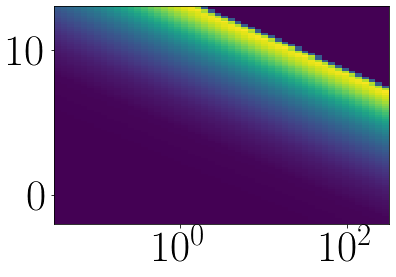

In [120]:
plt.pcolor(z_arr, M_arr, np.percentile(zM_cmpt_sf.sum(axis=2), (50), axis=2)[:,::-1])
plt.xscale('log')

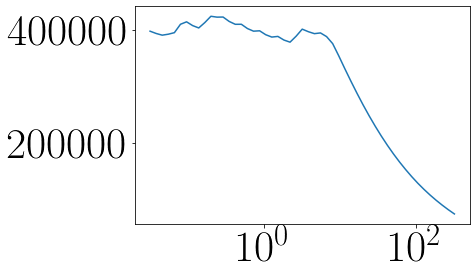

In [122]:
plt.plot(z_arr, np.percentile(zM_cmpt_sf.sum(axis=2), (50), axis=2).sum(axis=0))
plt.xscale('log')

In [103]:
z_cmpt_sf.shape

(51, 100)

In [100]:
z_cmpt_sf_pct.shape

(5, 51, 3)

In [3]:
import sys
sys.path

['/home/andy/Documents/Research/Projects/TracerDensity/mwtrace/gums',
 '/home/andy/Documents/Research/Projects/TracerDensity/mwtrace/gums',
 '/home/andy/Py_Packages/Agama/lib',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '',
 '/home/andy/py37/lib/python3.7/site-packages',
 '/home/andy/py37/lib/python3.7/site-packages/IPython/extensions',
 '/home/andy/.ipython']

In [4]:
import sys, os, pickle, time, warnings, h5py
import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py, emcee
from copy import deepcopy as copy
from multiprocessing import Pool

sys.path.extend(['../utilities/', '../models/', '../mockmodel/'])
import samplers, plotting, transformations, sf_utils
from transformations import func_inv_jac, func_labels, label_dict

import disk_halo_mstogap as dh_msto
# Load class instance
from TracerFit import mwfit, int_idx

In [12]:
# Apply Gaia Selection Function
from selectionfunctions.cog_v import subset_sf
import selectionfunctions.cog_ii as CoGii
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/testselectionfunctions/'
#CoGii.fetch()
dr3_sf = CoGii.dr3_sf(version='modelAB',crowding=False)

config['data_dir'] = '/data/asfe2/Projects/astrometry/PyOutput/'

# M = 85; C = 1; jmax=5; lm=0.3; nside=64; ncores=88; B=2.0
# map_fname = f"chisquare_astrometry_jmax{jmax}_nside{nside}_M{M}_CGR{C}_lm{lm}_B{B:.1f}_ncores{ncores}_scipy_results.h5"
M = 102; C = 1; jmax=5; lm=0.3; nside=64; ncores=88; B=2.0
map_fname = f"chisquare_ruwe1p4_jmax{jmax}_nside{nside}_M{M}_CGR{C}_lm{lm}lc200.0_B{B:.1f}_ncores{ncores}_scipy_results.h5"
ast_sf = subset_sf(map_fname=map_fname, nside=nside, 
                Mlim=[1.6,22], lengthscale_m=lm, lengthscale_c=200,
                basis_options={'needlet':'chisquare', 'j':jmax, 'B':B, 'p':1.0, 'wavelet_tol':1e-2},
                spherical_basis_directory='/data/asfe2/Projects/astrometry/SphericalWavelets/')

Loading auxilliary data ...
Loading selection function ...
Creating selection function interpolator...
t = 4.259 s
  auxilliary:   4.256 s
          sf:   0.002 s
interpolator:   0.001 s
Loading auxilliary data ...
Loading auxilliary data ...
t = 0.079 s
  auxilliary:   0.062 s
          sf:   0.000 s
interpolator:   0.017 s


In [ ]:
ast_sf.x[ast_sf.Mbins[:-1]>=20.7] = 0.

In [15]:
#run_id=1
file = "south_b80"#
sample = {};
smax=np.inf
magcuts = [-100,200]
utils_directory = '/data/asfe2/Projects/mwtrace_data/utils'
filename="/data/asfe2/Projects/mwtrace_data/gums/gums_%s.h" % file
with h5py.File(filename, 'r') as hf:
    rand_select = np.random.rand(len(hf['sample']['source_id']))<0.1
    print('faint', np.sum(hf['sample']['M'][...]>12))
    print('distant', np.sum(hf['sample']['s'][...]>smax))
    print('random', np.sum(rand_select))
    subset = (hf['sample']['s'][...]<smax)&(hf['sample']['M'][...]<12)&rand_select
    print('%d/%d' % (np.sum(subset), len(subset)))
    #subsample  = np.sort(np.random.choice(np.arange(np.sum(subset)), size=size, replace=False))
    for key in hf['sample'].keys():
        sample[key]=hf['sample'][key][...][subset]#[subsample]
size = len(sample['source_id'])

faint 3741
distant 0
random 60199
59833/602177


In [17]:
smax = np.inf#160

shared_pars = {'Mms1':9, 'Mms':8, 'Mms2':7}
fixed_pars = {'Mx':12, 'R0':8.27, 'theta_deg':80, 'Mms1':9, 'Mms':8, 'Mms2':7, 'smax':smax,
              0:dict({'alpha3':-0.6, 'Mto':3.1}, **shared_pars),
              1:dict({'alpha3':-0.73, 'Mto':3.1}, **shared_pars),
              2:dict({'alpha3':-0.64, 'Mto':3.1}, **shared_pars),
              'shd':{}}

free_pars = {}
free_pars[0] = ['w', 'hz', 'fD']#, 'alpha3']
free_pars[1] = ['w', 'hz', 'fD']#, 'alpha3']
free_pars[2] = ['w', 'hz', 'fD']#, 'alpha3']
free_pars['shd'] = ['alpha1', 'alpha2']
print("Free parameters: ", free_pars)

# Transformations
# transform, p1, p2, lower bound, upper bound
param_trans = {}
a_dirichlet = 2
param_trans['shd'] = {'alpha1':('nexp',0,0,-5,3,'none'),
                      'alpha2':('nexp',0,0,-5,3,'none')}
param_trans[0] = {'w':('exp',0,0,-10,50,'dirichlet',a_dirichlet),
                  'fD': ('logit_scaled', 0,1, -10,10,'logistic'),
                  'alpha3':('nexp',0,0,-3,3,'none'),
                  'hz': ('logit_scaled', 0.1,  0.6,-10,10,'logistic')}
param_trans[1] = {'w':('exp',0,0,-10,50,'dirichlet',a_dirichlet),
                  'fD': ('logit_scaled', 0,1,-10,10,'logistic'),
                  'alpha3':('nexp',0,0,-3,3,'none'),
                  'hz': ('logit_scaled', 0.6,3,-10,10,'logistic')}
param_trans[2] = {'w':('exp',0,0,-10,50,'dirichlet',a_dirichlet),
                  'fD': ('logit_scaled', 0,1,-10,10,'logistic'),
                  'alpha3':('nexp',0,0,-1,0,'none'),
                  'hz': ('logit_scaled', 3.,  7.3,-10,10,'logistic')}

Free parameters:  {0: ['w', 'hz', 'fD'], 1: ['w', 'hz', 'fD'], 2: ['w', 'hz', 'fD'], 'shd': ['alpha1', 'alpha2']}


In [28]:
    sample['astsf_subset'] = sf_utils.apply_subgaiasf(sample['l'], np.arcsin(sample['sinb']),
                                                      sample['m'], dr2_sf=dr3_sf, sub_sf=ast_sf, _nside=ast_sf.nside)[0]

Gaia SF prob
Sub SF prob


TypeError: query() got an unexpected keyword argument 'grid'

In [19]:
model_sf_err = mwfit(free_pars=free_pars, fixed_pars=fixed_pars, sample=sample, sf_bool=True, perr_bool=True, sub_sf=True, param_trans=param_trans)
model_sf_err.sample['sf_subset'] = sample['astsf_subset'].copy()
#model_sf_err.sample['sf_subset'] = sample['gaiasf_subset'].copy()
model_sf_err._generate_fid_pars(dr2_sf=dr3_sf, sub_sf=ast_sf, _m_grid=ast_sf.Mbins, _nside=ast_sf.nside, directory=utils_directory)

directory:  /data/asfe2/Projects/mwtrace_data/utils
Getting Selectionfunction pars
Higher Res:
Gaia SF:
Ast SF: (826, 103)
Got Selectionfunction pars


In [27]:
np.max(sample['m']), np.max(sample['m'][sample['astsf_subset']])

KeyError: 'astsf_subset'

In [ ]:
ast_sf

In [30]:
model_sf_err.fid_pars['gsf_pars']['_selectionfunction'][0][-20:]

array([9.70024750e-01, 9.72923738e-01, 9.73582951e-01, 9.73282010e-01,
       9.75829697e-01, 9.78715319e-01, 9.79386477e-01, 9.79645790e-01,
       9.76545082e-01, 9.68642962e-01, 9.56701845e-01, 9.31688123e-01,
       9.07026056e-01, 8.66086077e-01, 4.09005901e-01, 1.69111872e-03,
       3.29876889e-05, 3.36095978e-06, 8.34670287e-08, 0.00000000e+00])

In [31]:
ast_sf.Mbins[-20:]

array([18.28137255, 18.48235294, 18.68333333, 18.88431373, 19.08529412,
       19.28627451, 19.4872549 , 19.68823529, 19.88921569, 20.09019608,
       20.29117647, 20.49215686, 20.69313725, 20.89411765, 21.09509804,
       21.29607843, 21.49705882, 21.69803922, 21.89901961, 22.1       ])

In [36]:
np.arange(1.6,22.11,0.2).shape

(103,)

In [37]:
ast_sf.M

102

In [40]:
ast_sf??

In [39]:
np.linspace(ast_sf.Mlim[0], ast_sf.Mlim[1], 103)

array([ 1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,
        3.8,  4. ,  4.2,  4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,
        6. ,  6.2,  6.4,  6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,
        8.2,  8.4,  8.6,  8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2,
       10.4, 10.6, 10.8, 11. , 11.2, 11.4, 11.6, 11.8, 12. , 12.2, 12.4,
       12.6, 12.8, 13. , 13.2, 13.4, 13.6, 13.8, 14. , 14.2, 14.4, 14.6,
       14.8, 15. , 15.2, 15.4, 15.6, 15.8, 16. , 16.2, 16.4, 16.6, 16.8,
       17. , 17.2, 17.4, 17.6, 17.8, 18. , 18.2, 18.4, 18.6, 18.8, 19. ,
       19.2, 19.4, 19.6, 19.8, 20. , 20.2, 20.4, 20.6, 20.8, 21. , 21.2,
       21.4, 21.6, 21.8, 22. ])

In [32]:
ast_sf.Mbins[0]

1.6

In [ ]:
file = "south_b80"
    # Load Sample
    sample = {};
    smax = np.inf#160
    magcuts = [-100,200]
    utils_directory = '/data/asfe2/Projects/mwtrace_data/utils'
    filename="/data/asfe2/Projects/mwtrace_data/gums/gums_%s.h" % file
    with h5py.File(filename, 'r') as hf:
        rand_select = np.random.rand(len(hf['sample']['source_id']))<0.1
        print('faint', np.sum(hf['sample']['M'][...]>12))
        print('distant', np.sum(hf['sample']['s'][...]>smax))
        print('random', np.sum(rand_select))
        subset = (hf['sample']['s'][...]<smax)&(hf['sample']['M'][...]<12)&rand_select
        print('%d/%d' % (np.sum(subset), len(subset)))
        #subsample  = np.sort(np.random.choice(np.arange(np.sum(subset)), size=size, replace=False))
        for key in hf['sample'].keys():
            sample[key]=hf['sample'][key][...][subset]#[subsample]
    size = len(sample['source_id'])





    #ast_sf.Mbins = np.linspace(1.6,22,M+1)[15:]
    print("SF Mbins: ", ast_sf.Mbins)
    sample['astsf_subset'] = sf_utils.apply_subgaiasf(sample['l'], np.arcsin(sample['sinb']),
                                                      sample['m'], dr2_sf=dr3_sf, sub_sf=ast_sf, _nside=ast_sf.nside)[0]